# Deep Learning with *Dobble*

**Purpose**: A deep learning project centred around the card game *Dobble* (also known as *Spot It!*) using PyTorch.

**Context**: Graded hands-on project as part of the *Deep Learning* Seminar at [Justus Liebig University Giessen](https://www.uni-giessen.de)

**Authors**: 2023 Marvin Theiss, Nina Winkelmann

**License**: [GNU General Public License v3](https://www.gnu.org/licenses/gpl-3.0.html)

<br>

## Contents
- [Importing packages](#packages)
- [Part 1: The card game *Dobble*](#dobble-game)
    * [1.1 Finite projective planes](#finite-projective-planes)
- [Part 2: Creating our own *Dobble* playing cards](#dobble-cards)
    * [2.1 Empty playing cards](#dobble-cards-empty-cards)
    * [2.2 Emojis](#dobble-cards-emojis)
    * [2.3 Circle packing](#dobble-cards-circle-packing)
    * [2.4 Finite projective planes](#dobble-cards-projective-planes)
    * [2.5 *Dobble* decks](#dobble-cards-decks)
    * [2.6 Pairs of cards](#dobble-cards-pairs)
- [Part 3: Setting up a deep learning pipeline](#deep-learning-pipeline)
    * [3.1 Generating datasets](#deep-learning-pipeline-datasets)
    * [3.2 Utility functions](#deep-learning-pipeline-utility-functions)
    * [3.3 Training and testing routines](#deep-learning-pipeline-routines)
    * [3.4 Learning rate scheduler *REX*](#deep-learning-pipeline-lr-scheduler)
    * [3.5 Transforming and augmenting images](#deep-learning-pipeline-augmentation)
- [Part 4: *ResNet* models with different depths](#resnet-models)
    * [4.1 ResNet-18](#resnet-models-resnet18)

<a id='packages'></a>

### Importing packages
Before we start, we import all the packages that we'll be using later on. We follow the recommended order of ordering imports in Python, i.e.,
1. standard library imports
2. third-party library imports
3. local imports (not applicable here)

In [1]:
import csv
import itertools
from math import log2
import os
import random
import warnings

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import torch
import torch.nn as nn
from torchvision import models, transforms

<a id='dobble-game'></a>

## Part 1: The card game *Dobble*
[*Dobble*](https://www.dobblegame.com/en/homepage/) is a **popular card game** that challenges players to spot matching symbols between pairs of cards. It was created by *Denis Blanchot* and *Jacques Cottereau* and has gained significant popularity due to its simple yet engaging gameplay.

<br>
<img src="https://www.dobblegame.com/wp-content/uploads/sites/2/2020/12/dobble_eclate_pageaccueil-2.png" style="margin:auto"/>
<br>
<p style="text-align: center">
    <i>Copyright 2023 by Dobble. All rights reserved.</i>
</p>
<br>

At first glance, a deck of Dobble cards may seem like a random collection of symbols, but there is an **underlying mathematical structure** that governs the game. Each card in the deck features multiple symbols, and the goal is to find the one symbol that matches with another card in the deck. The mathematical concept that *Dobble* is based on is known as a **finite projective plane**. In a finite projective plane, there are a finite number of points and lines, and certain properties hold true (we will expand on this later on). In the case of *Dobble*, the cards represent lines in the projective plane, while the symbols on the cards represent points.

The key idea of *Dobble* is that every pair of cards in the deck will have **exactly one** symbol in common. This property is what makes Dobble intriguing and challenging. The number of symbols on each card determines the order of the finite projective plane, with the order being one less than the number of symbols (again, we'll get back to this later).

By utilizing the principles of finite projective planes, one can systematically construct a deck of *Dobble* cards such that every card has a unique set of symbols, and any two cards will always share exactly one symbol. There are several well-written articles covering the mathematical structure underlying *Dobble*. Here is a non-exhaustive list:
- [The maths behind Dobble](https://mickydore.medium.com/dobble-theory-and-implementation-ff21ddbb5318) by *Micky Dore*
- [Finite Projective Planes and the Math of Spot It!](https://puzzlewocky.com/games/the-math-of-spot-it/) on *puzzlewocky.com*
- [The Mathematics of Toys and Games](https://www.petercollingridge.co.uk/blog/mathematics-toys-and-games/dobble/) by *Peter Collingridge*
- [Dobble](https://en.wikipedia.org/wiki/Dobble) on *Wikipedia*

Also, a diploma thesis (in German) focusing on the math behind *Dobble* can be found here:
- [Ein Einblick in die Mathematik hinter dem Kartenspiel Dobble](https://unipub.uni-graz.at/obvugrhs/download/pdf/6499156?originalFilename=true) by *Christian Kathrein*

<a id='finite-projective-planes'></a>

### 1.1 Finite projective planes
We have claimed that a deck of *Dobble* cards is essentially a finite projective plane where cards in the deck correspond to lines in the projective plane and the symbols on any particular card correspond to the points on a specific line. But, what is a *finite projective plane* to begin with? Let's start with a concept that all of us will be very familiar with: the **Euclidean plane**.


<font color = red>**TO-DO:**</font> Continue this part!

Some **key aspects** of projective planes to keep in mind:
- Each projective plane (finite or infinite) has as many lines as it has points.
- For every *finite* projective plane, there exists an integer $n \geq 2$ such that ...
    * the number of points and lines is given by $n^2 + n + 1$,
    * there are $n + 1$ points on each line,
    * there are $n + 1$ lines passing through each point.
- This number $n$ is called the **order** of the projective plane.

#### On the existence of finite projective planes
It is known that there exists a projective plane of order $n = p^k$ for every *prime power* $p^k$. What's perhaps even more intriguing is the fact that, as of today, **all** known finite projective planes are of order $p^k$ for some prime number $p$.

<font color = red>**TO-DO:**</font> Continue this part (and whole chapter)!

<a id='dobble-cards'></a>

## Part 2: Creating our own *Dobble* playing cards
Essentially, there are (at least) two alternatives to generate the data needed to train a network so that it learns to play the card game *Dobble*. Either, one purchases (or already owns) the actual game and takes pictures of all of the individual cards, or one generates their own *Dobble* playing cards from scratch. For this project, we chose the second option, i.e., we decided to generate images of custom *Dobble* cards using popular image-processing libraries such as [OpenCV](https://pypi.org/project/opencv-python/) and [Pillow](https://pypi.org/project/Pillow/).

This approach has several *advantages*, so let's just highlight a few of the more important ones:
- **Multiple decks of cards**: Instead of being stuck with a single deck of cards, we can (theoretically) generate infinitely many different sets.
- **Full control over the dataset**: We can control every last detail of our *Dobble* cards. For example, we can control the color of the individual symbols, their size, their placement on the card, and so on.
- **Easier data generation**: When working with networks, we aim to feed images of pairs of cards into the networks and then ask the networks to find the unique symbol that is present on both cards. For a classic deck of *Dobble* cards, there are 1,596 possible combinations of cards. Manually taking pictures of all of these pairs of cards would be immensely time-consuming. On the contrary, generating images of pairs of cards is straightforward once all of the individual cards have been created.

##### Here's how we will go about creating our datasets
First, we need to generate images of individual cards. To do so, we first have to create **empty playing cards**. This is going to be easy as this equates to generating square images of a white disk against a transparent background. Next, we need to find an **open-source library of emojis** that we can use as the symbols on our *Dobble* cards. Once we have that, we need to find a way to **place** these **individual emojis** onto the empty playing cards without having emojis overlap. If possible, we want to replicate the way that the symbols are arranged on actual *Dobble* cards: The centers of the individual symbols vary across cards and so do the sizes of the symbols. After we have implemented the necessary algorithms to achieve this, we are in the position to **generate individual *Dobble*-like playing cards**. Next, we need to come up with an algorithm that tells us **which emojis to place on which card** so that every two cards will share one and only one common emoji. Essentially, this boils down to implementing an algorithm that computes the incidence matrix of a finite projective plane of a given order. Given such an algorithm we can **systematically create all the cards** that make up a full deck of *Dobble* playing cards. Finally, we need to **find all pairs of cards**, which will serve as the dataset(s) for our project.

Let's start by implementing a function that returns an empty playing card. This should be easy.

<a id='dobble-cards-empty-cards'></a>

### 2.1 Empty playing cards
As just mentioned, the starting point for our custom *Dobble* playing cards will be square images consisting of nothing but a white disk against a transparent background.

In [2]:
def create_empty_card(image_size, return_pil=True):
    """Create a square image of a white disk against a transparent background.

    Args:
        image_size (int): The size of the square image in pixels.
        return_pil (bool): Whether to return a PIL Image ('True') or a NumPy array ('False').  Defaults to 'True'.

    Returns:
        PIL.Image.Image or np.ndarray: The generated image of a white disk against a transparent background.
    """
    # Create a new transparent image with RGBA mode
    image = Image.new('RGBA', (image_size, image_size), (0, 0, 0, 0))
    
    # Create a new draw object
    draw = ImageDraw.Draw(image)
    
    # Calculate the coordinates of the disk to maximize its size within the square image
    disk_x = image_size // 2
    disk_y = image_size // 2
    radius = image_size // 2
    
    # Draw a white disk on the image
    draw.ellipse((disk_x - radius, disk_y - radius,
                  disk_x + radius, disk_y + radius),
                 fill=(255, 255, 255, 255))
    
    if return_pil:
        return image
    else:
        # Convert the image to a NumPy array
        image_np = np.array(image)
        return image_np


Let's check out what this looks like. To actually see the white disk, we make the transparent background fully opaque.

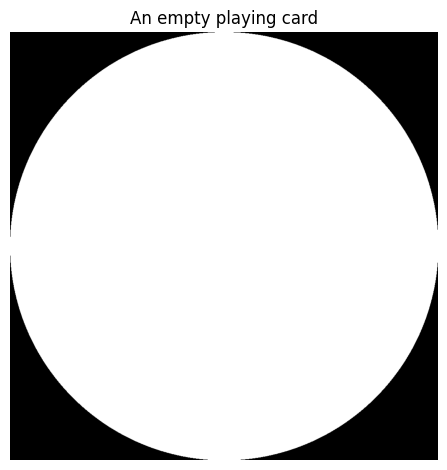

In [3]:
image_size = 1024
empty_playing_card = create_empty_card(image_size, return_pil=False)
empty_playing_card[..., 3] = 255

plt.imshow(empty_playing_card)
plt.title('An empty playing card')
plt.axis('off')
plt.tight_layout()
plt.show()

Now, let's move on to the fun part: emojis.

<a id='dobble-cards-emojis'></a>

### 2.2 Emojis
The emojis for this project are taken from [OpenMoji](https://openmoji.org) and are free to use under the [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/) license, which is compatible with the [GNU General Public License v3](https://www.gnu.org/licenses/gpl-3.0.en.html). Information on the compatibility of *CC BY-SA 4.0* with *GPLv3* can be found [here](https://creativecommons.org/share-your-work/licensing-considerations/compatible-licenses).

We have manually downloaded the emojis and placed them into the following directory (relative to this notebook): `../data/external/emojis/classic-dobble/`. Inside this directory, there are two subdirectories called `color` and `outline`. These contain the colored versions of the emojis and just their outlines, respectively. 

**Note**: The directory `../data/external/emojis/` is the general directory where we will store different sets of emojis (e.g., animals, food, etc.). Each of these sets should then include the two subdirectories `color` and `outline` containing the corresponding images. As of right now, we have only downloaded a single set of emojis (i.e., `classic-dobble`).

In [4]:
EMOJIS_DIR = os.path.join('..', 'data', 'external', 'emojis')

To create our playing cards, we will need to be able to **obtain the names of all emojis available in a given set** of emojis (i.e., directory) at once. Let's implement a function that does just that.

In [5]:
def get_emoji_names(emoji_set, outline_only=False):
    """Retrieve the names of all emojis in the specified set of emojis.

    Args:
        emoji_set (str): The name of the emoji set to use (e.g., 'classic-dobble').
        outline_only (bool): Specifies whether to retrieve names of emojis with outline only.  Defaults to 'False'.

    Returns:
        list[str]: A list of names of all emojis in the specified set.
    """
    if outline_only:
        dir_path = os.path.join(EMOJIS_DIR, emoji_set, 'outline')
    else:
        dir_path = os.path.join(EMOJIS_DIR, emoji_set, 'color')
    
    emoji_names = []
    for file in os.listdir(dir_path):
        if file.endswith('.png'):
            # Extract the base name without extension (i.e., without '.png')
            emoji_name = os.path.splitext(file)[0]
            emoji_names.append(emoji_name)
    emoji_names.sort()
    
    return emoji_names


To make sure that this function works as expected, let's print the names of all the emojis of the `classic-dobble` set.

In [6]:
classic_dobble_emoji_names = get_emoji_names('classic-dobble')
for name in classic_dobble_emoji_names:
    print(name)

anchor
babybottle
bison
bomb
cactus
candle
carrot
cheesewedge
chesspawn
clownface
deciduoustree
dogface
dragon
droplet
drunkperson
eye
fire
fourleafclover
ghost
greenapple
grinningcatwithsmilingeyes
hammer
handwithfingerssplayed
heart
highheeledshoe
highvoltage
ice
key
ladybeetle
lastquartermoonface
lightbulb
locked
mapleleaf
microbe
mountfuji
mouth
musicalscore
oncomingpolicecar
pencil
redexclamationmark
redquestionmark
rosette
scissors
skullandcrossbones
snowflake
snowmanwithoutsnow
spider
spiderweb
spoutingwhale
stopsign
sunglasses
sunwithface
timer
trex
turtle
twitter
yinyang


Next, we need a function that takes as input the name of the set of emojis (e.g., `classic-dobble`) as well as the name of the emoji (e.g., `dogface`) and then **loads the corresponding emoji image into memory** and returns it.

In [7]:
def load_emoji(emoji_set, emoji_name, outline_only=False, return_pil=True):
    """Load an emoji from the specified set of emojis.

    Args:
        emoji_set (str): The name of the set of emojis (e.g., 'classic-dobble').
        emoji_name (str): The name of the emoji to load.
        outline_only (bool): Whether to load the outline-only version of the emoji.  Defaults to 'False'.
        return_pil (bool): Whether to return a PIL Image ('True') or a NumPy array ('False').  Defaults to 'True'.

    Returns:
        PIL.Image.Image or np.ndarray: The loaded emoji image.

    Raises:
        ValueError: If the specified emoji file is not found or does not have a valid PNG extension.
    """
    # Create the file path pointing to the emoji that we want to load
    if outline_only:
        which_type = 'outline'
    else:
        which_type = 'color'
    file_path = os.path.join(EMOJIS_DIR, emoji_set, which_type, emoji_name + '.png')

    # Check if the file exists and if it has the correct extension
    if os.path.isfile(file_path) and file_path.lower().endswith('.png'):
        emoji_image = Image.open(file_path)

        # Convert the image to RGBA mode if it's not already
        if emoji_image.mode != 'RGBA':
            emoji_image = emoji_image.convert('RGBA')

        if return_pil:
            return emoji_image
        else:
            # Convert the image to a NumPy array
            emoji_image_np = np.array(emoji_image)
            return emoji_image_np
    else:
        raise ValueError(f'Failed to load emoji: {file_path} is not a valid PNG file.')


Let's use this function to visualize all the emojis in the `classic-dobble` set.

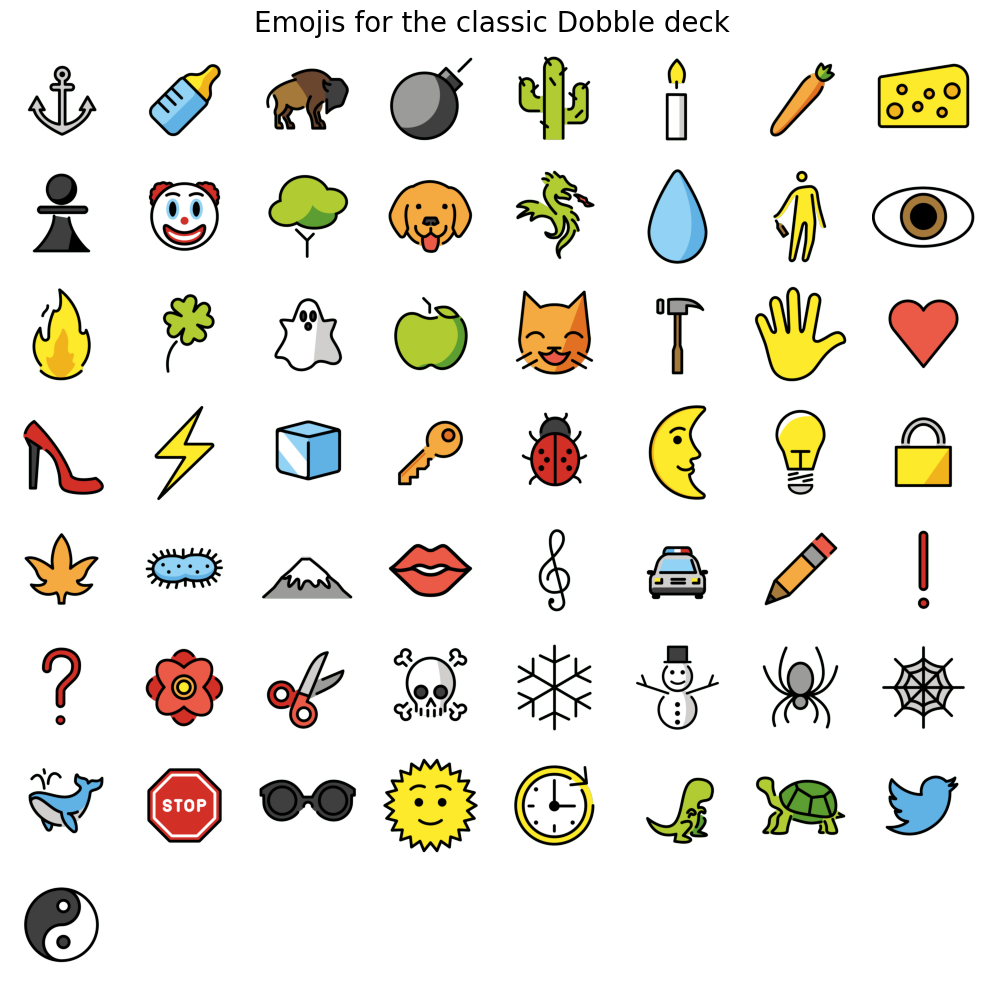

In [8]:
fig, axes = plt.subplots(8, 8, figsize=(10, 10))

for count, ax in enumerate(axes.flat):
    if count < len(classic_dobble_emoji_names):  # Check if there are still emojis remaining
        emoji_image_np = load_emoji(
            'classic-dobble', classic_dobble_emoji_names[count], return_pil=False
            )
        ax.imshow(emoji_image_np)
        ax.axis('off')
    else:
        ax.axis('off')

plt.suptitle('Emojis for the classic Dobble deck', size=20)
plt.tight_layout()
plt.show()

By now, we know which emojis exist in which set and we can load any of these emojis into memory. Next, we need a function that **pastes an individual emoji** onto another image (which will be our playing card, of course).

In [9]:
def place_emoji(image, emoji_image, emoji_size, emoji_center, rotation_angle=None, return_pil=True):
    """Place an emoji on the given image at the specified coordinates with the specified size.

    Args:
        image (PIL.Image.Image): The original image as a PIL Image.
        emoji_image (PIL.Image.Image): The emoji as a PIL Image.
        emoji_size (int): The desired size of the emoji in pixels when placed on the image.
        emoji_center (tuple): The center coordinates of the emoji in the form (x, y).
        rotation_angle (float): The rotation angle in degrees.  Defaults to 'None'.
        return_pil (bool): Whether to return a PIL Image ('True') or a NumPy array ('False').  Defaults to 'True'.

    Returns:
        PIL.Image.Image or np.ndarray: The modified image with the emoji placed on it.

    Raises:
        ValueError: If the 'rotation_angle' is provided but is outside of the valid range of [0, 360).
    """
    x_center, y_center = emoji_center
    
    # Calculate the top-left coordinates of the emoji based on the center coordinates and size
    x_left = x_center - emoji_size // 2
    y_top = y_center - emoji_size // 2

    # Resize the emoji to the specified size
    emoji_image = emoji_image.resize((emoji_size, emoji_size))

    # Check if a rotation angle was specified and validate it
    if rotation_angle:
        if rotation_angle < 0 or rotation_angle >= 360:
            raise ValueError('Invalid rotation angle: must be in the range [0, 360).')
        
        # Rotate the image if the rotation angle is valid
        emoji_image = emoji_image.rotate(rotation_angle)

    # Paste the emoji onto the original image at the specified coordinates
    image.paste(emoji_image, (x_left, y_top), mask=emoji_image)

    if return_pil:
        return image
    else:
        # Convert the image to a NumPy array
        image_np = np.array(image)
        return image_np


Let's take the `fourleafclover` emoji, rotate it by 15 degrees clockwise, and place it onto the empty playing card we created earlier.

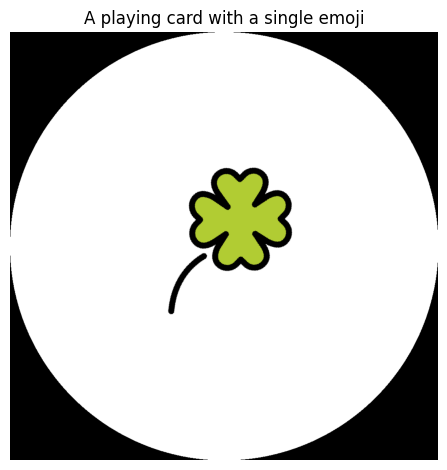

In [10]:
empty_playing_card = create_empty_card(1024)
dogface_image = load_emoji('classic-dobble', 'fourleafclover')
emoji_size = 512
center = (512, 512)
rotation_angle = 345  # 15 degrees clockwise correspond to 345 degrees counterclockwise
playing_card_with_single_emoji = place_emoji(
    empty_playing_card, dogface_image, emoji_size, center, rotation_angle, return_pil=False
    )
playing_card_with_single_emoji[..., 3] = 255

plt.imshow(playing_card_with_single_emoji)
plt.title('A playing card with a single emoji')
plt.axis('off')
plt.tight_layout()
plt.show()

Now that the fun part is done, we need to find a **systematic way of placing multiple emojis** onto a single playing card. When doing so, we want to ...
* utilize the available space of each playing card as much as possible,
* make sure that no two emojis overlap.

To accomplish this, we rely on results from a mathematical branch called *circle packing*.

<a id='dobble-cards-circle-packing'></a>

### 2.3 Circle packing
Why do we need to deal with the theory of *circle packing*? Well, here is an extract of the [Wikipedia article](https://en.wikipedia.org/wiki/Circle_packing) on the theory of circle packing:

> *In geometry, circle packing is the study of the arrangement of circles (of equal or varying sizes) on a given surface such that **no overlapping** occurs and so that **no circle can be enlarged without creating an overlap**.*

Sounds familiar? Loosely speaking, packings satisfying the two conditions highlighted in **bold** are called *optimal*. So, here's the general approach we will take: For a given number $n$ of emojis that we want to place on a playing card, we choose an optimal circle packing consisting of $n$ circles and we center each emoji on the center of one of the circles. The size of the emoji will be determined by the size of the corresponding circle (i.e., its diameter). This works out quite well since ...
* the emojis provided by [OpenMoji](https://openmoji.org) are square images (618 x 618 pixels) with a transparent background,
* most emojis do not extend much into the corners of the image due to the [styleguide](https://openmoji.org/styleguide/#styleguide) that's used by [OpenMoji](https://openmoji.org).

Thus, all we need are optimal packings for different numbers of circles. That way we can create *Dobble* decks with varying numbers of symbols per card. Ideally, we also have multiple (optimal) packings for a fixed number of circles. This would allow us to have different layouts across playing cards of a single deck. Luckily, Prof. Dr.-Ing. [Eckehard Specht](https://www.ltv.ovgu.de/Mitarbeiter/Lehrstuhlinhaber/Prof_+Eckehard+Specht-p-210.html) provides an incredible amount of data on optimal packings on his website [packomania.com](http://www.packomania.com). From this website, we have downloaded the data that we need and placed it into the following directory (relative to this notebook): `../data/external/packings/`.

In [11]:
PACKINGS_DIR = os.path.join('..', 'data', 'external', 'packings')

 Inside this directory, there are the following five subdirectories:

- `cci`
- `ccib`
- `ccic`
- `ccir`
- `ccis`

The names of these subdirectories are simply the names that Prof. Dr.-Ing. Eckehard Specht uses for the different types of packings that he provides on his website (e.g., the data in the `cci` directory was taken from [http://hydra.nat.uni-magdeburg.de/packing/**cci**/**cci**.html](http://hydra.nat.uni-magdeburg.de/packing/cci/cci.html)). All of these subdirectories qualitatively contain the same data:

- Multiple text files containing the **coordinates of each circle** in the packing. The file names consist of the name of the directory followed by the number of circles in the circle packing (e.g., `cci4.txt` or `ccir32.txt`). All text files consist of three columns: the first column stores a simple counter, the second column contains the $x$-coordinate, and the third column contains the $y$-coordinate of the center of each circle. The coordinates of these circle centers have to be interpreted in relation to the large circle that contains all of the smaller circles. This large circle is centered at $(0, 0)$ and has a radius of $1$, i.e., it is defined by the equation $x^2 + y^2 = 1$.
- A single text file `radius.txt` that stores the **radius of the largest circle** of each circle packing. This file contains two columns: the first one specifies the number of circles in the circle packing and the second one provides the radius of the largest circle in the packing. The radii of all the other circles can be computed based on this radius. We will get back to this later. As was the case for the coordinate values, these radii have to be interpreted in relation to the radius of the large circle containing all of the smaller circles.

Generally, this data is available for circle packings where the number of circles are integers up to $n = 50$ that can be expressed as $p^k + 1$ with $p$ being prime (i.e., integers that immediately follow a prime power).

<font color=red>**Important:**</font> For $n = 3, 4$ this data is **only** available for circle packings of type `cci`.

Next, let's define a dictionary `PACKING_TYPES_DICT` that stores all the different types of packings that are available in our directory `../data/external/packings/`. The value associated with each key is a tuple consisting of ...
- a function that can be used to compute the remaining radii of a circle packing of that type,
- a string that indicates whether this function is monotonically increasing or decreasing.

In [12]:
PACKING_TYPES_DICT = {
    'cci': (lambda n: 1, 'increasing'),
    'ccir': (lambda n: n ** (1/2), 'increasing'),
    'ccis': (lambda n: n ** (-1/2), 'decreasing'),
    'ccib': (lambda n: n ** (-1/5), 'decreasing'),
    'ccic': (lambda n: n ** (-2/3), 'decreasing')
}

We now have all the raw data that we need for our project. What's needed now, is a **set of functions that allows us to conveniently access this data**. Essentially, we want to be able to specify

* the type of packing that we want to use (i.e., one of the keys in the `PACKING_TYPES_DICT`),
* the number of emojis that we want to place on a playing card,
* the size of the playing card in pixels (i.e., the size of the square image of a white disk against a transparent background),

and we want to get back the coordinates (in pixels) of where to place each emoji as well as each emoji's size (in pixels). We could then use this information to iteratively place single emojis on our playing cards using the `place_emoji` function. Let's break the process of reading in and preprocessing the packing data down into three simple steps:

1. Read in the raw data (i.e., coordinates of all circles and radius of the largest circle) for a given packing
2. Based on the radius of the largest circle and the type of packing, compute the radii of all remaining circles in the packing
3. Convert the data into pixel values based on the size of the playing card that ought to be generated

Let's start with the first step of **reading in the raw data**.

In [13]:
def read_coordinates_from_file(num_circles, packing_type):
    """Read the coordinates of the specified circle packing from a text file.

    Args:
        num_circles (int): Number of circles in the packing.
        packing_type (str): Type of circle packing.

    Returns:
        list[list[float]]: A list of coordinates of all the circles in the packing.

    Raises:
        FileNotFoundError: If the text file for the specified packing type and number of circles is not found.
    """
    file_name = os.path.join(PACKINGS_DIR, packing_type, packing_type + str(num_circles) + '.txt')

    try:
        with open(file_name, 'r') as file:
            # Read values line by line, split into separate columns and get rid of first column of text file
            coordinates = [line.strip().split()[1:] for line in file.readlines()]
            coordinates = [[float(coordinate) for coordinate in coordinates_list] for coordinates_list in coordinates]
        return coordinates
    except FileNotFoundError:
        raise FileNotFoundError(f"Coordinates file for '{packing_type}' packing with {num_circles} circles not found.")


def read_radius_from_file(num_circles, packing_type):
    """Read the radius of the largest circle of the specified circle packing from a text file.

    Args:
        num_circles (int): Number of circles in the packing.
        packing_type (str): Type of circle packing.

    Returns:
        float: The radius of the largest circle of the packing.

    Raises:
        FileNotFoundError: If the 'radius.txt' file for the specified packing type is not found.
        ValueError: If no radius is found for the specified packing type and number of circles.
    """
    file_name = os.path.join(PACKINGS_DIR, packing_type, 'radius.txt')

    try:
        with open(file_name, 'r') as file:
            for line in file:
                values = line.strip().split()
                if len(values) == 2 and int(values[0]) == num_circles:
                    return float(values[1])

        raise ValueError(f"No radius found for packing type '{packing_type}' with {num_circles} circles.")
    except FileNotFoundError:
        raise FileNotFoundError(f"Radius file for '{packing_type}' packing not found.")


As mentioned before, the `radius.txt` file in each subdirectory contains only the radius of the largest circle in each packing. The radii of the remaining circle can be computed as follows: Each type of packing is described by the radii of the circle it's made up of. For example, the radii (relative to the radius of the largest circle in the packing) of the packings of type `ccir` are described by the function $r_i = \sqrt{i}$. Let's look at a concrete example: Assume that we want to compute the radii of all of the circles in a packing of type `ccir` with $5$ circles. The function $r_i$ then yields the following values:
* $r_1 = \sqrt{1} = 1$
* $r_2 = \sqrt{2} \approx 1.4142$
* $r_3 = \sqrt{3} \approx 1.7321$
* $r_4 = \sqrt{4} = 2$
* $r_5 = \sqrt{5} \approx 2.2361$

As we can see right away, these are not the final radii (remember that the large circle that contains all the smaller circles only has a radius of 1!). Instead, these values simply describe the ratios of the circles in a packing *relative to each other*. To obtain the absolute radii, we first take the radius of the largest circle in the packing (which we obtain from the `radius.txt` file) and divide it by the largest value of the sequence of values $r_1, \dots, r_5$. In this particular case, this gives us $0.49454334 / 2.2361 \approx 0.2212$. All we need to do now is multiply the sequence of values $r_1, \dots, r_5$ by this constant factor to obtain the final radii:
* $r_1 \times 0.2212 \approx 0.2212$
* $r_2 \times 0.2212 \approx 0.3128$
* $r_3 \times 0.2212 \approx 0.3831$
* $r_4 \times 0.2212 \approx 0.4423$
* $r_5 \times 0.2212 \approx 0.4945$

These are the actual radii that we were looking for. Note that the final value in the list above coincides with the radius supplied in the `radius.txt` file. This is no coincidence because this value was computed as
$$
r_5 \times 0.2212 = r_5 \times \frac{0.4945}{r_5} = 0.4945 \, .
$$

Let's turn all of this into a function!

In [14]:
def compute_radii(num_circles, packing_type, largest_radius):
    """Compute the radii of circles in a circle packing.

    Args:
        num_circles (int): Total number of circles in the packing.
        packing_type (str): Type of circle packing.
        largest_radius (float): Radius of the largest circle in the packing.

    Returns:
        list[float]: The computed radii of the circles in the packing.
    """
    radius_function, monotonicity = PACKING_TYPES_DICT[packing_type]
    function_values = [radius_function(n+1) for n in range(num_circles)]

    # If the function 'radius_function' is decreasing, we reverse the order of 'function_values'
    # so that the values are listed in increasing order
    if monotonicity == 'decreasing':
        function_values.reverse()
    
    ratio = largest_radius / function_values[-1]
    radii = [function_values[n] * ratio for n in range(num_circles)]

    return radii


Now that we have both, the circle centers as well as the radii, we need to convert these values into pixel values based on the size of the square image that will serve as our playing card. This is easy.

In [15]:
def convert_coordinates_to_pixels(rel_coordinates, image_size):
    """Convert relative coordinates to pixel values based on the size of a square image.

    The function takes relative coordinates in the range of [-1, 1] and converts them to pixel values
    based on the size of a square image.  The relative coordinates are assumed to be in a normalized form,
    where the origin (0, 0) corresponds to the center of the image and the values (-1, -1) and (1, 1)
    correspond to the lower left and upper right corner of the image, respectively.

    Args:
        rel_coordinates (np.ndarray or tuple): Relative coordinates in the range of [-1, 1] in the form (x, y).
        image_size (int): Size of the square image that coordinates are to be based on.

    Returns:
        tuple[int, int]: Pixel values corresponding to the relative coordinates.

    Raises:
        ValueError: If the relative coordinates are outside of the range of [-1, 1].
    """
    # Convert rel_coords to NumPy array if necessary
    if not isinstance(rel_coordinates, np.ndarray):
        rel_coordinates = np.array(rel_coordinates)

    # Check if the relative coordinates are within the range of [-1, 1]
    if np.any((rel_coordinates < -1) | (rel_coordinates > 1)):
        raise ValueError('Relative coordinates must be in the range of [-1, 1].')
    
    # Shift coordinates from [-1, 1] to [0, 1]
    rel_coordinates = rel_coordinates / 2 + 0.5

    # Scale coordinates from [0, 1] to [0, card_size] and convert to integer values
    coordinates = np.floor(rel_coordinates * image_size).astype('int')

    return tuple(coordinates)


def convert_radius_to_pixels(rel_radius, image_size):
    """Convert relative radius to pixel value based on the size of a square image.

    Args:
        rel_radius (float): Relative radius in the range of [0, 1].
        image_size (int): Size of the square image that radii are to be based on.

    Returns:
        int: Pixel value corresponding to the relative radius.

    Raises:
        ValueError: If the relative radius is outside the valid range of [0, 1].
    """
    if rel_radius < 0 or rel_radius > 1:
        raise ValueError('Relative radius must be in the range of [0, 1].')

    size = int(rel_radius * image_size)
    
    return size


Finally, let's **combine** all these individual steps **into one, easy-to-use function**.

In [16]:
def get_packing_data(num_circles, packing_type, image_size):
    """
    Args:
        num_circles (int): Total number of circles in the packing.
        packing_type (str): Type of circle packing.
        image_size (int): Size of the square image that coordinates and radii are to be based on.

    Returns:
        dict[str, list]: A dcitionary containing the coordinates and sizes in pixel values.

    Raises:
        ValueError: If the packing type is not one of the supported packing types.
    """
    if packing_type not in PACKING_TYPES_DICT:
        raise ValueError(f"Invalid packing type: '{packing_type}' is not supported.")

    # Coordinates
    rel_coordinates_array = read_coordinates_from_file(num_circles, packing_type)
    coordinates = [
        convert_coordinates_to_pixels(rel_coordinates, image_size) for rel_coordinates in rel_coordinates_array
        ]

    # Sizes
    largest_radius = read_radius_from_file(num_circles, packing_type)
    rel_radii = compute_radii(num_circles, packing_type, largest_radius)
    sizes = [convert_radius_to_pixels(rel_radius, image_size) for rel_radius in rel_radii]

    # Combine into dictionary
    packing_data = {
        'coordinates': coordinates,
        'sizes': sizes
        }
    
    return packing_data


To make sure that everything is working as expected, let us **visualize a few circle packings**.

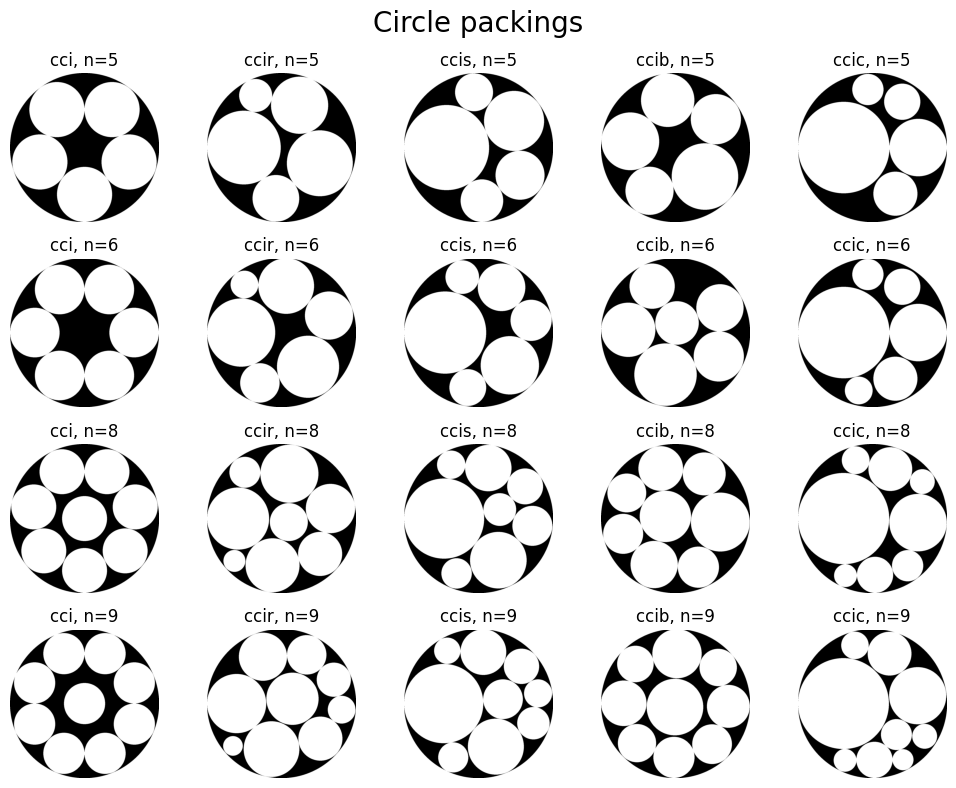

In [17]:
num_circles_list = [5, 6, 8, 9]
image_size = 1024

# Visualize different numbers of circles across rows and different packing types across columns
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

for row, num_circles in enumerate(num_circles_list):
    for col, packing_type in enumerate(PACKING_TYPES_DICT):
        # Obtain packing data
        packing_data = get_packing_data(num_circles, packing_type, image_size)
        
        # Create emtpy card
        packing = create_empty_card(image_size)

        # Iteratively draw circles on card
        for circle in range(num_circles):
            center_x, center_y = packing_data['coordinates'][circle]
            radius = packing_data['sizes'][circle] // 2

            draw = ImageDraw.Draw(packing)
            draw.ellipse(
                (center_x - radius, center_y - radius, center_x + radius, center_y + radius),
                fill=0
                )

        # Convert to NumPy array
        packing_np = np.array(packing)

        # Make the image fully opaque (i.e., turn transparent background black)
        packing_np[..., 3] = 255

        # Separate color channels and alpha channel
        color_channels = packing_np[..., :3]
        alpha_channel = packing_np[..., 3]

        # Invert color channels
        inverted_color_channels = 255 - color_channels

        # Combine inverted color channels with alpha channel
        packing_np = np.concatenate((inverted_color_channels, alpha_channel[..., np.newaxis]), axis=2)
        
        axes[row, col].imshow(packing_np)
        title = f'{packing_type}, n={num_circles}'
        axes[row, col].set_title(title)
        axes[row, col].axis('off')

plt.suptitle('Circle packings', size=20)
plt.tight_layout()
plt.show()

<a id='dobble-cards-projective-planes'></a>

### 2.4 Finite projective planes
In the first chapter of this notebook, we have already established that a deck of *Dobble* playing cards corresponds to a finite projective plane, where the order of the latter is one less than the number of symbols on each card. Thus, to create a valid *Dobble* deck (i.e., a set of playing cards such that each pair of cards shares exactly one symbol), we need to compute the so-called *incidence matrix* of its corresponding projective plane. This incidence matrix tells us which points belong to which line (or in *Dobble* terms: which symbol should go on which card).

Since the construction we want to use (called the *vector space construction with finite fields*) to construct finite projective planes only works for orders $n = p^k$ that are prime powers, let's quickly implement **two functions** that we can use to **check whether a given integer is a prime power or not**.

In [18]:
def is_prime(num):
    """Check if a number is prime.

    Args:
        num (float): The number to be checked.

    Returns:
        bool: 'True' if the number is prime, 'False' otherwise.
    """
    is_integer = isinstance(num, int) or (isinstance(num, float) and num.is_integer())
    
    if not is_integer or num <= 1:
        return False

    # Check for non-trivial factors
    for i in range(2, int(num**0.5) + 1):
        if num % i == 0:
            return False
    return True


def is_prime_power(num):
    """Check if a number is a prime power.

    Args:
        num (float): The number to be checked.

    Returns:
        bool: 'True' if the number is a prime power, 'False' otherwise.
    """
    is_integer = isinstance(num, int) or (isinstance(num, float) and num.is_integer())
    
    if not is_integer or num <= 1:
        return False

    # Compute the i-th root of num and check if it's prime
    for i in range(1, int(log2(num)) + 1):
        root = num ** (1/i)
        if root.is_integer() and is_prime(root):
            return True
    return False


Now that we have this, let's implement an algorithm that constructs the incidence matrix for a finite projective plane of order $n = p^k$, with $p$ being a prime number.

**Note**: The function `compute_incidence_matrix` is based on the algorithm presented in the article [The Dobble Algorithm](https://mickydore.medium.com/the-dobble-algorithm-b9c9018afc52) by *Micky Dore*.

In [19]:
def compute_incidence_matrix(order):
    """Compute the incidence matrix of a finite projective plane with specified order.

    Args:
        order (int): The order of the finite projective plane.

    Returns:
        np.ndarray: The computed incidence matrix.  Rows correspond to lines and columns correspond to points.

    Raises:
        ValueError: If the argument 'order' is not a prime power.

    Example:
        >>> compute_incidence_matrix(2)
        array([[ True,  True,  True, False, False, False, False],
               [ True, False, False,  True,  True, False, False],
               [ True, False, False, False, False,  True,  True],
               [False,  True, False,  True, False,  True, False],
               [False,  True, False, False,  True, False,  True],
               [False, False,  True,  True, False, False,  True],
               [False, False,  True, False,  True,  True, False]])
    """
    if not is_prime_power(order):
        raise ValueError("The 'order' argument must be a prime power.")
    
    # Number of points/lines of a finite projective plane of order n is given by n^2 + n + 1
    size = order**2 + order + 1
    
    # Preallocate incidence matrix, where rows correspond to lines and columns correspond to points
    incidence_matrix = np.zeros((size, size), dtype=bool)

    # Determine which points are on the first line
    which_line = 0
    which_pts = list(range(order + 1))
    incidence_matrix[which_line, which_pts] = True

    # Determine which points are on the next n lines
    for line in range(order):
        which_line += 1
        # The first n + 1 lines will all share point '0'
        which_pts = [0]
        start = (line + 1) * order + 1
        end = start + order
        which_pts.extend(list(range(start, end)))
        incidence_matrix[which_line, which_pts] = True
    
    # Determine which points are on the final n^2 lines
    for block in range(order):
        for line in range(order):
            which_line += 1
            which_pts = [block + 1]
            for pt in range(order):
                which_pts.append(order * (pt + 1) + ((block * pt + line) % order) + 1)
            incidence_matrix[which_line, which_pts] = True
    
    return incidence_matrix


<a id='dobble-cards-decks'></a>

### 2.5 *Dobble* decks
We now have everything that we need to create our own custom *Dobble* decks. Here, we throw everything together into a single function that creates a full set of playing cards. Before we do so, let's quickly implement a function that **generates a single playing card**.

In [20]:
def create_dobble_card(image_size, packing_type, emoji_set, emoji_list, outline_only=False, return_pil=True):
    """Create a single Dobble playing card.

    Args:
        image_size (int): The size of the square image in pixels.
        packing_type (str): The type of circle packing.
        emoji_set (str): The name of the set of emojis (e.g., 'classic-dobble')
        emoji_list (list): The list of names of the emojis to be placed on the playing card.
        outline_only (bool): Whether to load the outline-only version of the emoji.  Defaults to 'False'.
        return_pil (bool): Whether to return a PIL Image ('True') or a NumPy array ('False').  Defaults to 'True'.

    Returns:
        PIL.Image.Image or np.ndarray: The generated image of a Dobble playing card.
    """
    dobble_card = create_empty_card(image_size)
    num_emojis = len(emoji_list)
    packing_data = get_packing_data(num_emojis, packing_type, image_size)

    # Place emojis on card
    for count, emoji_name in enumerate(emoji_list):
        emoji_image = load_emoji(emoji_set, emoji_name, outline_only)
        emoji_size = packing_data['sizes'][count]
        emoji_center = packing_data['coordinates'][count]
        rotation_angle = random.randint(0, 359)
        dobble_card = place_emoji(dobble_card, emoji_image, emoji_size, emoji_center, rotation_angle)

    if return_pil:
        return dobble_card
    else:
        # Convert the image to a NumPy array
        dobble_card_np = np.array(dobble_card)
        return dobble_card_np


To make sure that this function works as expected, let's **visualize a few custom playing cards**.

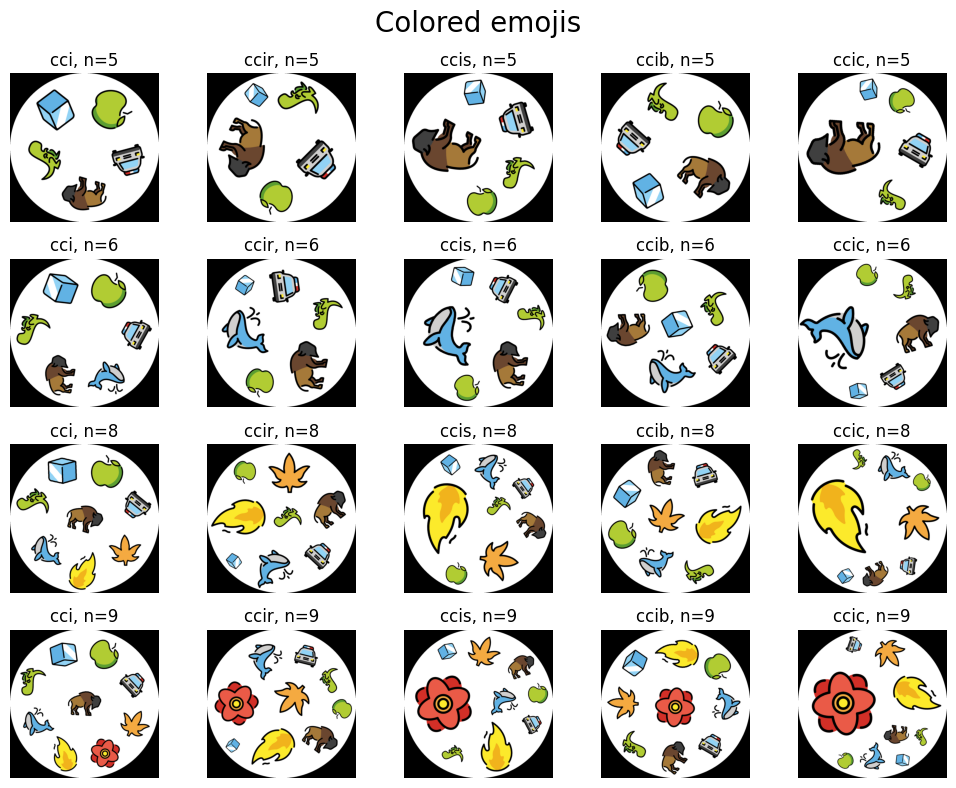

In [21]:
card_size = 1024
emoji_set = 'classic-dobble'
emoji_lists = [
    ['ice', 'greenapple', 'trex', 'oncomingpolicecar', 'bison'],
    ['ice', 'greenapple', 'trex', 'oncomingpolicecar', 'bison', 'spoutingwhale'],
    ['ice', 'greenapple', 'trex', 'oncomingpolicecar', 'bison', 'spoutingwhale', 'mapleleaf', 'fire'],
    ['ice', 'greenapple', 'trex', 'oncomingpolicecar', 'bison', 'spoutingwhale', 'mapleleaf', 'fire', 'rosette']
    ]

# Visualize different numbers of symbols per card across rows and different packing types across columns
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

for row, emoji_list in enumerate(emoji_lists):
    for col, packing_type in enumerate(PACKING_TYPES_DICT):
        dobble_card_np = create_dobble_card(
            card_size, packing_type, emoji_set, emoji_list, return_pil=False
            )
        
        # Make the image fully opaque (i.e., turn transparent background black)
        dobble_card_np[..., 3] = 255
        
        axes[row, col].imshow(dobble_card_np)
        title = f'{packing_type}, n={len(emoji_list)}'
        axes[row, col].set_title(title)
        axes[row, col].axis('off')

plt.suptitle('Colored emojis', size=20)
plt.tight_layout()
plt.show()

Also, let's see what it looks like if we only use the **outlined emojis**.

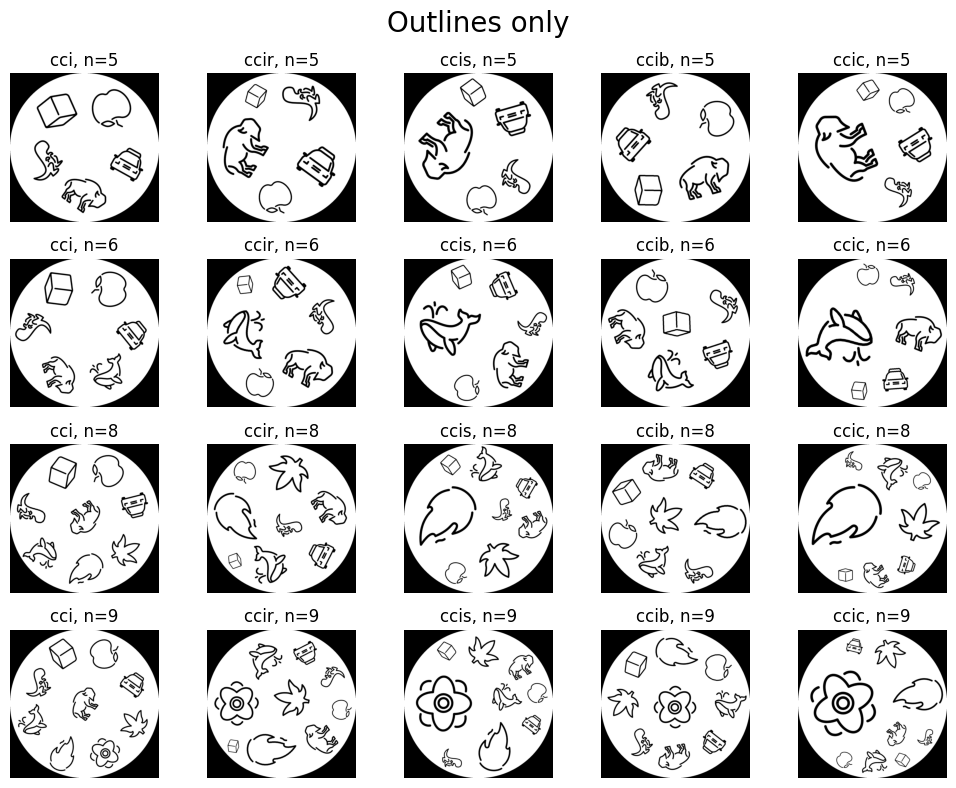

In [22]:
# Visualize different numbers of symbols per card across rows and different packing types across columns
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

for row, emoji_list in enumerate(emoji_lists):
    for col, packing_type in enumerate(PACKING_TYPES_DICT):
        dobble_card_np = create_dobble_card(
            card_size, packing_type, emoji_set, emoji_list, return_pil=False, outline_only=True
            )
        
        # Make the image fully opaque (i.e., turn transparent background black)
        dobble_card_np[..., 3] = 255
        
        axes[row, col].imshow(dobble_card_np)
        title = f'{packing_type}, n={len(emoji_list)}'
        axes[row, col].set_title(title)
        axes[row, col].axis('off')

plt.suptitle('Outlines only', size=20)
plt.tight_layout()
plt.show()

Since everything is working fine, let's move on and create a full deck of custom *Dobble* playing cards. First, we set up a directory to store all of the generated decks.

In [23]:
DATA_DIR = os.path.join('..', 'data', 'processed')

Next, let's think for a moment about the **parameters** that we want to be able to control when creating a new deck of playing cards:
* `emoji_set` **Which set of emojis** do we want to use?
* `num_emojis` **How many emojis** do we want **on each card**? Remember that this number needs to be equal to $p^k + 1$ with $p$ being prime (i.e., an integer that immediately follows a prime power).
* `image_size` **How large** (in pixels) should each image be?
* `deck_name` What do we want to call our newly created deck? This will also serve as the **name of the subdirectory** of the directory, where we will store the images.
* `outline_only` Do we want to use the **colored versions** of the emojis **or** just their **outlines**?
* `packing_type` Do we want to use one **type of circle packing** for all cards or do we want to choose the packing type randomly for each card to have greater variability between cards?

Finally, here is an **outline of the individual steps** we need to take to create our custom deck of playing cards:
1. Using the `deck_name` parameter, create a subdirectory to store the generated images.
2. Compute the incidence matrix of the finite projective plane of the appropriate order (Remember: The order of the projective plane is one less than the number of symbols on each card!). We make use of the `compute_incidence_matrix` function to achieve this.
3. Read in the names of all the emojis available in the specified `emoji_set`. We use the `get_emoji_names` function to do so.
    * Make sure that there are enough emojis available in this set! The number of distinct emojis needed in total is derived from the `num_emojis`. If there aren't enough, throw an error. If there are too many, choose a random subset of the appropriate size.
4. Set up a CSV file that will store all the necessary information to create the ground-truth labels later on (i.e., which is the common symbol between any pair of cards?).
5. Finally, create the playing cards one by one. This is done as follows:
    * The incidence matrix generated by the `compute_incidence_matrix` function tells us which emojis need to be placed on which card (i.e., the entries in the $i$-th row determine the emojis that need to be placed on the $i$-th playing card).
    * Select the names of the corresponding emojis from the `emoji_names` list that we created earlier using the `get_emoji_names` function.
    * Shuffle this list to randomly place the emojis on the card and create the playing card with the `create_dobble_card` function.
    * Finally, append all the relevant information about the card that was just generated to the CSV file created earlier.

In [24]:
def create_dobble_deck_images(
        emoji_set, num_emojis, image_size, deck_name, outline_only=False, packing_type=None):
    """Create a full set of playing cards (i.e., generate and save images).

    Args:
        emoji_set (str): The name of the set of emojis (e.g., 'classic-dobble') to use.
        num_emojis (int): The number of emojis to place on each card.
        image_size (int): The size of each square image (of a single playing card) in pixels.
        deck_name (str): The name of the deck.  Will also be used to create the subdirectory
            that stores all of the generated images.
        outline_only (bool): Whether to generate playing cards with outline-only emojis.  Defaults to 'False'.
        packing_type (str): The type of packing to use for placing emojis on the cards.
            If not provided, a packing type is randomly chosen for each card.  Defaults to 'None'.

    Returns:
        tuple[str, str]: A tuple containing the file paths to the generated CSV files that store all
            information about the playing cards ('deck.csv') as well as the emoji labels ('emoji_labels.csv').
    """
    deck_dir = os.path.join(DATA_DIR, deck_name)  # directory to store the images
    csv_dir = os.path.join(deck_dir, 'csv')  # directory to store all the information about the deck
                                  
    # If the 'csv_dir' already exists (i.e., the deck has already been created),
    # we simply return the two CSV files that would be created by this function
    if os.path.exists(csv_dir):
        deck_csv = os.path.join(csv_dir, 'deck.csv')
        emoji_labels_csv = os.path.join(csv_dir, 'emoji_labels.csv')
        return deck_csv, emoji_labels_csv
    else:
        os.makedirs(csv_dir)
    
    # Compute incidence matrix of corresponding finite projective plane
    order = num_emojis - 1
    incidence_matrix = compute_incidence_matrix(order)

    # The number of cards in a deck is given by n^2 + n + 1, with n + 1 = # symbols on each card
    # NOTE: Remember that there are as many distinct symbols in a deck as there are cards
    num_cards = order ** 2 + order + 1

    # Read in the names of all emojis in the specified 'emoji_set'
    emoji_names = get_emoji_names(emoji_set, outline_only)

    # Check if there are enough emojis in the specified subdirectory
    num_emojis_available = len(emoji_names)
    if num_emojis_available < num_cards:
        raise ValueError('Not enough emojis in the specified set to create the Dobble deck.')
    elif num_emojis_available > num_cards:
        # If there are more emojis than we need, we randomly choose a subset of the appropriate size
        emoji_names = random.sample(emoji_names, num_cards)

    # Create CSV file to store information about the individual emojis and their corresponding labels
    emoji_labels = pd.DataFrame({'EmojiName': emoji_names, 'EmojiLabel': range(len(emoji_names))})
    emoji_labels_csv = os.path.join(csv_dir, 'emoji_labels.csv')
    emoji_labels.to_csv(emoji_labels_csv, index=False)

    # If no 'packing_type' was provided initially, choose one randomly each time from
    # the 'packing_types_dict' dictionary
    choose_randomly = True if packing_type is None else False

    # Create CSV file to store information about the individual cards
    deck_csv = os.path.join(csv_dir, 'deck.csv')
    with open(deck_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['FilePath'] + ['PackingType'] + ['Emoji' + str(i+1) for i in range(num_emojis)])
    
    # Create playing cards one-by-one using the incidence matrix to decide which emojis to put on which card
    # NOTE: len(a) is equivalent to np.shape(a)[0] for N-D arrays with N>=1.
    for card in range(len(incidence_matrix)):
        # Find the emojis that are to be placed on the card
        which_emojis = np.where(incidence_matrix[card])[0]
        emoji_list = [emoji_names[idx] for idx in which_emojis]
        random.shuffle(emoji_list)
        
        # If no 'packing_type' was provided initially, choose one randomly from the 'PACKING_TYPES_DICT' dictionary
        if choose_randomly:
            packing_type = random.choice(list(PACKING_TYPES_DICT.keys()))
        
        # Create playing card and save in directory
        dobble_card = create_dobble_card(image_size, packing_type, emoji_set, emoji_list, outline_only)
        file_name = f'{deck_name}_{card + 1:03d}.png'
        file_path = os.path.join(deck_dir, file_name)
        dobble_card.save(file_path)

        # Write card information to the CSV file
        with open(deck_csv, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([file_path] + [packing_type] + emoji_list)

    return deck_csv, emoji_labels_csv


Let's test this function and create and then visualize our first custom deck of *Dobble* playing cards!

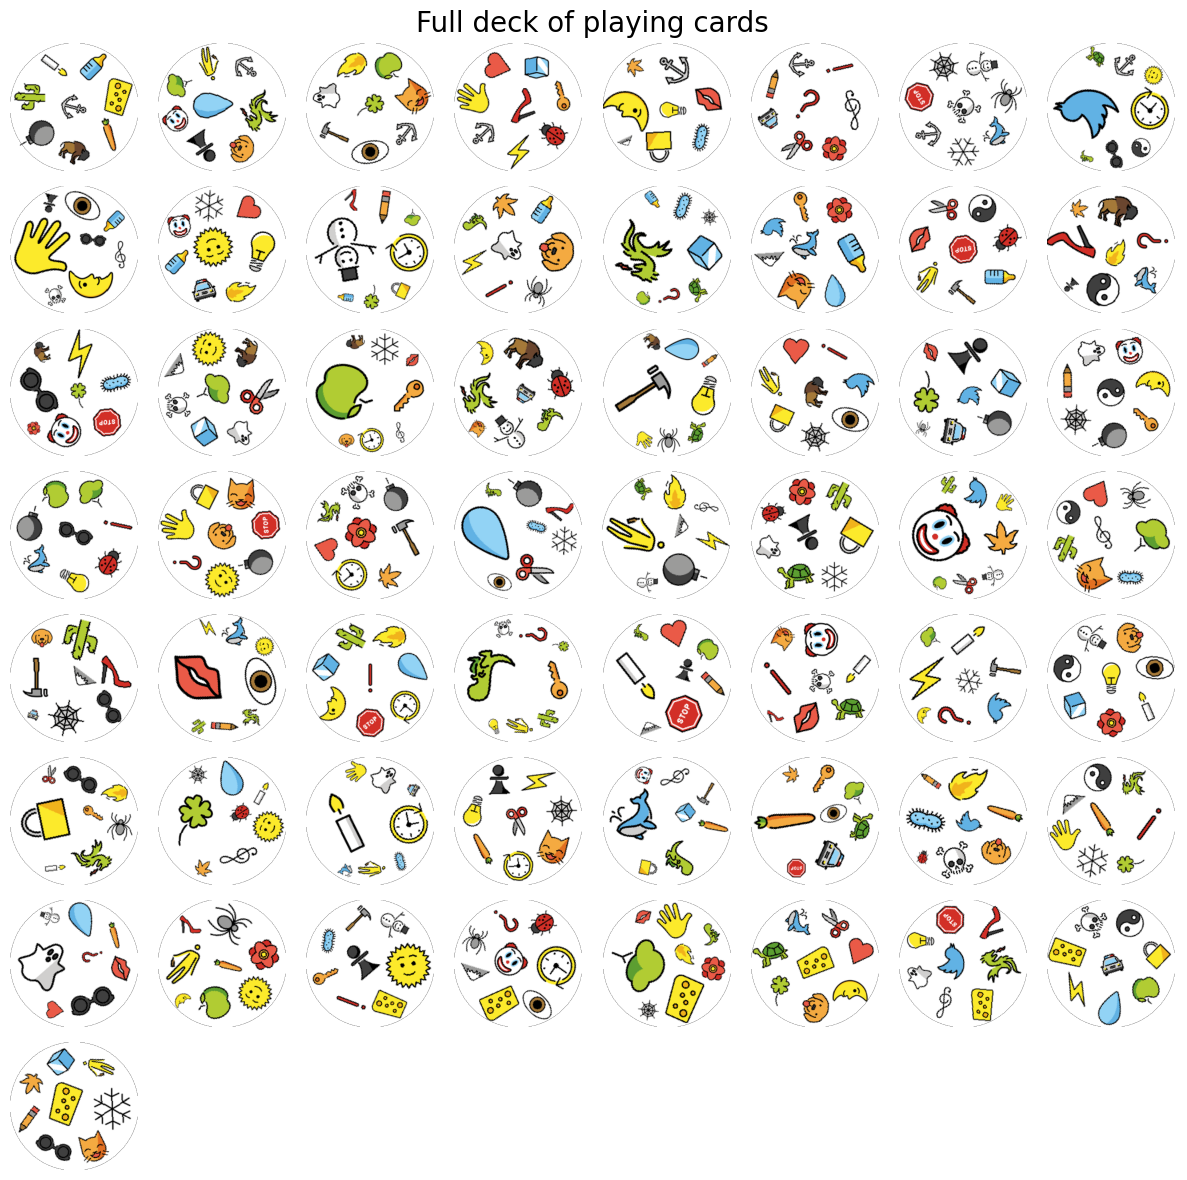

In [25]:
emoji_set = 'classic-dobble'
num_emojis = 8
image_size = 224
deck_name = 'classic-dobble'

deck_csv, emoji_labels_csv = create_dobble_deck_images(
    emoji_set, num_emojis, image_size, deck_name
    )

# Visualize all 7^2 + 7 + 1 = 57 cards in an 8x8 layout
fig, axes = plt.subplots(8, 8, figsize=(12, 12))
image_paths = pd.read_csv(deck_csv)['FilePath'].values.tolist()  # extract file paths to images

for count, ax in enumerate(axes.flat):
    if count < len(image_paths):
        image = Image.open(image_paths[count])
        image_np = np.array(image)
        # image_np[..., 3] = 255  # make the image fully opaque
        ax.imshow(image_np)
        ax.axis('off')
    else:
        ax.axis('off')

plt.suptitle('Full deck of playing cards', size=20)
plt.tight_layout()
plt.show()

<a id='dobble-cards-pairs'></a>

### 2.6 Pairs of cards
When training networks, we want to pass images that display pairs of playing cards so that the network has to find the unique emoji shared by the two playing cards in the image. To achieve this, we will create a square image of a uniformly colored background, divide it into four quadrants of equal size, and then place two playing cards into two of these quadrants.

First, let's write a function that computes the coordinates of where the playing cards need to be positioned based on the quadrant that they are supposed to be placed in.

In [26]:
def compute_quadrant_coordinates(quadrant, image_size):
    """Compute the coordinates of a specified quadrant within a square image.

    Args:
        quadrant (int): The quadrant number, ranging from 1 to 4.
        image_size (int): The size of the square image.

    Returns:
        tuple[int, int]: The upper left coordinates (x, y) of the specified quadrant within the square image.

    Raises:
        ValueError: If an invalid 'quadrant' (number) is provided.
    """
    quadrant_size = image_size // 2
    
    if quadrant == 1:  # upper right
        coords = (quadrant_size, 0)
    elif quadrant == 2:  # upper left
        coords = (0, 0)
    elif quadrant == 3:  # lower left
        coords = (0, quadrant_size)
    elif quadrant == 4:  # lower right
        coords = (quadrant_size, quadrant_size)
    else:
        raise ValueError('Invalid quadrant. Please provide a value from 1 to 4.')

    return coords


Next, we write a function that returns the desired **images of pairs of cards**.

In [27]:
def create_tile_image(image1, image2, quadrants, bg_color=None, return_pil=True):
    """Create a tile image by combining two square images based on the specified quadrants.

    Args:
        image1 (PIL.Image.Image): The first input image to place on the tile image.
        image2 (PIL.Image.Image): The second input image to place on the tile image.
        quadrants (tuple[int, int]): Tuple of integers from 1 to 4 representing the quadrants in which
            the two images will be placed.
        bg_color (tuple[int, int, int]): The RGB color tuple for the background color.  Defaults to 'None'.
        return_pil (bool): Whether to return a PIL Image ('True') or a NumPy array ('False').  Defaults to 'True'.

    Returns:
        PIL.Image.Image or np.ndarray: The generated tile image.
    
    Raises:
        ValueError: If two identical quadrants are provided.
    """
    if quadrants[0] == quadrants[1]:
        raise ValueError('Two identical quadrants provided. Images would overlap.')

    tile_image_size = 2 * image1.width

    # Choose random background color if 'bg_color' was not specified
    if bg_color is None:
        bg_color = tuple(np.random.randint(0, 256, size=3, dtype=np.uint8))
    
    tile_image = Image.new('RGBA', (tile_image_size, tile_image_size), bg_color)

    image1_pos = compute_quadrant_coordinates(quadrants[0], tile_image_size)
    image2_pos = compute_quadrant_coordinates(quadrants[1], tile_image_size)

    tile_image.paste(image1, image1_pos, mask=image1)
    tile_image.paste(image2, image2_pos, mask=image2)

    if return_pil:
        return tile_image
    else:
        # Convert the image to a NumPy array
        tile_image_np = np.array(tile_image)
        return tile_image_np


Let's make sure that this function works as expected. We choose two arbitrary cards from our set of playing cards that we have already created and then arrange them into a single image using the `create_tile_image` function.

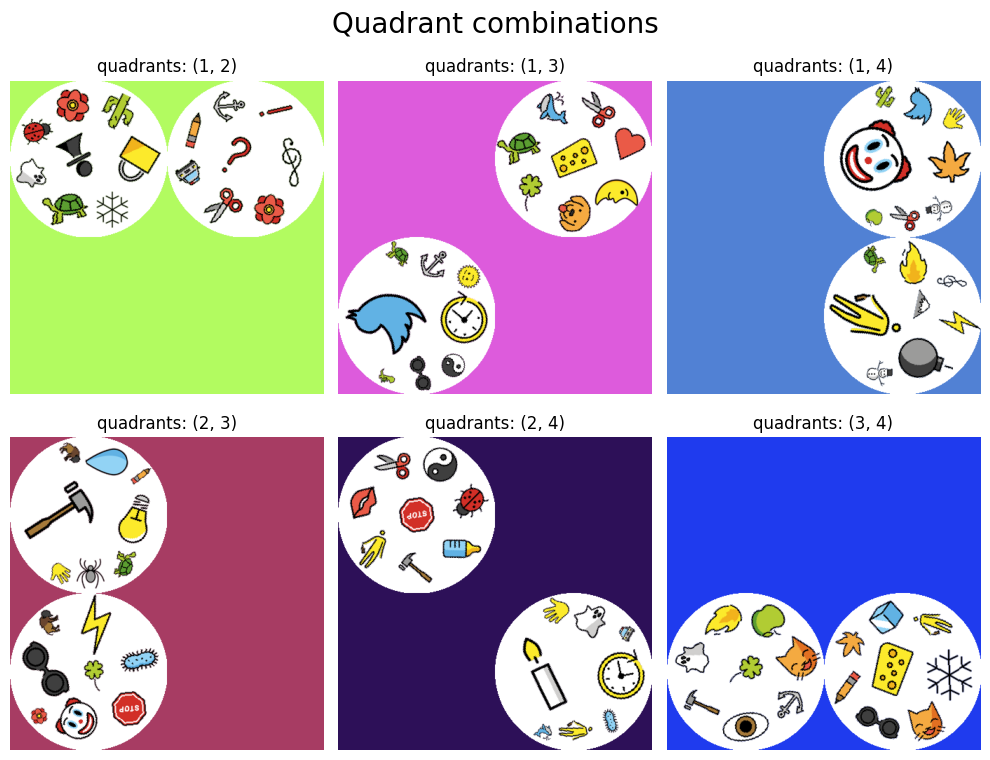

In [28]:
# NOTE: The file paths to the images of our playing cards are still stored in the 'image_paths' variable!
num_cards = len(image_paths)

fig, axes = plt.subplots(2, 3, figsize=(10, 8))
axes = axes.flatten()
count = 0

for pos1 in range(1, 4):
    for pos2 in range(pos1 + 1, 5):
        image1_idx, image2_idx = random.sample(range(0, num_cards), 2)
        image1 = Image.open(image_paths[image1_idx])
        image2 = Image.open(image_paths[image2_idx])
        quadrants = (pos1, pos2)
        tile_image_np = create_tile_image(image1, image2, quadrants, return_pil=False)

        ax = axes[count]
        count += 1
        
        ax.imshow(tile_image_np)
        ax.set_title(f'quadrants: {quadrants}')
        ax.axis('off')

plt.suptitle('Quadrant combinations', size=20)
plt.tight_layout()
plt.show()

<a id='deep-learning-pipeline'></a>

## Part 3: Setting up a deep learning pipeline
We can now create custom data (images of custom *Dobble* playing cards) to use in our deep learning project. Next, let's prepare all the necessary tools that we need to set up our deep learning pipeline (e.g., dataset generation, training routines, etc.).

<a id='deep-learning-pipeline-datasets'></a>

### 3.1 Generating datasets
So far, when we create a new set of playing cards (i.e., images), we automatically generate two CSV files: one containing general information about the deck (e.g., where are the images stored, which emojis are placed on which card) and one containing a mapping between integer labels and emoji names. What we also need is a **CSV file that contains all possible pairs of playing cards**. This is exactly what we'll take care of next.

In [29]:
def pair_up_cards(deck_csv, emoji_labels_csv):
    """Create a CSV file containing all possible combinations of playing cards in a Dobble deck.

    Args:
        deck_csv (str): The file path to the CSV file generated by the 'create_dobble_deck_images' function.

    Returns:
        str: The file path to the created CSV file 'pairs.csv'.
    """
    # Check if 'pairs' CSV has already been created
    csv_dir = os.path.dirname(deck_csv)
    pairs_csv = os.path.join(csv_dir, 'pairs.csv')
    if os.path.exists(pairs_csv):
        return pairs_csv

    # Read the card information from the 'deck_csv' file into a list of lists,
    # where inner lists correspond to rows of the CSV file
    with open(deck_csv, 'r') as f:
        reader = csv.reader(f)
        next(reader)  # Skip header
        deck_info = list(reader)

    # Read the mapping information (i.e., emoji names to integers) from the CSV file 'emoji_labels_csv'
    emoji_labels_df = pd.read_csv(emoji_labels_csv)
    
    # Generate all combinations of pairs of cards (ignoring the order of cards)
    card_pairs = itertools.combinations(deck_info, 2)

    with open(pairs_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Card1Path', 'Card2Path', 'CommonEmojiLabel'])

        # Iterate over each pair of cards
        for pair in card_pairs:
            card1_path = pair[0][0]  # Extract file path of the first card
            card2_path = pair[1][0]  # Extract file path of the second card
            emojis1 = pair[0][2:]    # Extract names of emojis that are placed on the first card
            emojis2 = pair[1][2:]    # Extract names of emojis that are placed on the second card
    
            # Find the common emoji between the two cards
            common_emoji = (set(emojis1) & set(emojis2)).pop()
            common_emoji_label = emoji_labels_df.loc[
                emoji_labels_df['EmojiName'] == common_emoji, 'EmojiLabel'
                ].iloc[0]

            # Write data to CSV file
            writer.writerow([card1_path, card2_path, common_emoji_label])
    
    return pairs_csv


Let's create the **CSV file that contains all the possible pairs of cards** of our recently created Dobble deck. If everything works as expected, this CSV file should contain $(57 * 56) / 2 = 1596$ entries (not counting the header).

In [30]:
pairs_csv = pair_up_cards(deck_csv, emoji_labels_csv)

Next, we simply combine the two functions `create_dobble_deck_images` and `pair_up_cards` into a single function that (if not done already) creates a full deck of custom *Dobble* playing cards and also creates all the necessary CSV files (deck information, emoji labels mapping, and pairs of cards) in one go.

In [31]:
def prepare_dobble_dataset(
        emoji_set, num_emojis, image_size, deck_name, outline_only=False, packing_type=None):
    """Prepare a full dataset of playing cards (i.e., generate and save images, pair up playing cards).

    Args:
        emoji_set (str): The name of the set of emojis (e.g., 'classic-dobble') to use.
        num_emojis (int): The number of emojis to place on each card.
        image_size (int): The size of each square image (of a single playing card) in pixels.
        deck_name (str): The name of the deck.  Will also be used to create the subdirectory
            that stores all of the generated images.
        outline_only (bool): Whether to generate playing cards with outline-only emojis.  Defaults to 'False'.
        packing_type (str): The type of packing to use for placing emojis on the cards.
            If not provided, a packing type is randomly chosen for each card.  Defaults to 'None'.

    Returns:
        tuple[str, str, str]: A tuple containing the file paths to the generated CSV files that store all
            information about the playing cards ('deck.csv'), the emoji labels ('emoji_labels.csv'),
            and all pairs of cards ('pairs.csv'), in that order.
    """
    deck_csv, emoji_labels_csv = create_dobble_deck_images(
        emoji_set, num_emojis, image_size, deck_name, outline_only, packing_type
        )
    pairs_csv = pair_up_cards(deck_csv, emoji_labels_csv)

    return deck_csv, emoji_labels_csv, pairs_csv


As always, let's double-check that this function works as expected!

In [32]:
emoji_set = 'classic-dobble'
num_emojis = 8
image_size = 224
deck_name = 'classic-dobble'

csv_files = prepare_dobble_dataset(emoji_set, num_emojis, image_size, deck_name)

for csv_file in csv_files:
    print(csv_file)

../data/processed/classic-dobble/csv/deck.csv
../data/processed/classic-dobble/csv/emoji_labels.csv
../data/processed/classic-dobble/csv/pairs.csv


The `pairs_csv` file that we created earlier (which is also contained as the last entry in the `csv_files` tuple) describes the full dataset that we can work with. For training purposes, we want to **split this dataset into three subsets** that can be used for training, validation, and testing.

In [33]:
def split_dataset(dataset_csv, train_ratio, val_ratio):
    """Split a dataset given by a CSV file into three subsets: train, validation, and test.

    Args:
        dataset_csv (str): Path to the original CSV file.
        train_ratio (float): Proportion of the dataset for the training set (between 0 and 1).
        val_ratio (float): Proportion of the dataset for the validation set (between 0 and 1).

    Returns:
        tuple[str, str, str]: A tuple containing the file paths for the train, validation, and test CSV files.

    Raises:
        ValueError: If the sum of 'train_ratio' and 'val_ratio' is greater than 1.
    """
    if train_ratio + val_ratio > 1:
        raise ValueError("The sum of 'train_ratio' and 'val_ratio' cannot exceed 1.")
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(dataset_csv)

    # Randomly shuffle the DataFrame's rows
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Calculate the number of samples for each subset
    num_all = len(df)
    num_train = int(num_all * train_ratio)
    num_val = int(num_all * val_ratio)
    num_test = num_all - num_train - num_val

    # Split into train, validation, and test subsets
    train_df = df[:num_train]
    val_df = df[num_train:num_train+num_val]
    test_df = df[num_train+num_val:]

    # Extract the directory path of the 'dataset_csv' file and construct file paths for the output CSV files
    dir_path = os.path.dirname(dataset_csv)
    train_csv = os.path.join(dir_path, 'train.csv')
    val_csv = os.path.join(dir_path, 'val.csv')
    test_csv = os.path.join(dir_path, 'test.csv')
    
    # Write the subsets to separate CSV files
    train_df.to_csv(train_csv, index=False)
    val_df.to_csv(val_csv, index=False)
    test_df.to_csv(test_csv, index=False)

    return train_csv, val_csv, test_csv


Let's test this function to see if it works as expected.

In [34]:
train_ratio = 0.7
val_ratio = 0.15

dataset_csvs = split_dataset(pairs_csv, train_ratio, val_ratio)

for dataset_csv in dataset_csvs:
    print(dataset_csv)

../data/processed/classic-dobble/csv/train.csv
../data/processed/classic-dobble/csv/val.csv
../data/processed/classic-dobble/csv/test.csv


At this point, we have prepared all of the data so that it can be used to train a network. Next, we define a **custom dataset class** that we'll name `DobbleDataset`. This class takes as input the path to the CSV file holding the dataset information (e.g., the `train_csv`, `val_csv`, or `test_csv` file paths generated by the `split_dataset` function), a background color for the tile images of pairs of cards, a transform that is applied to the images of the individual playing cards, and two transforms that are sequentially applied to the final tile image. Note that the last four parameters are optional. If any transform is not provided, then the corresponding transformation is simply not performed. If the background color is not supplied, it is chosen randomly by the `create_tile_image` function.

In [35]:
class DobbleDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_csv, bg_color=None, individual_transform=None, tile_transform=None, preprocess=None):
        self.image_paths = pd.read_csv(dataset_csv)[['Card1Path', 'Card2Path']]
        self.labels = pd.read_csv(dataset_csv)['CommonEmojiLabel']
        self.bg_color = bg_color
        self.individual_transform = individual_transform
        self.tile_transform = tile_transform
        self.preprocess = preprocess

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        card1_path = self.image_paths.loc[idx, 'Card1Path']
        card2_path = self.image_paths.loc[idx, 'Card2Path']
        card1_image = Image.open(card1_path)
        card2_image = Image.open(card2_path)

        # Apply individual transforms to the card images if provided
        if self.individual_transform:
            card1_image = self.individual_transform(card1_image)
            card2_image = self.individual_transform(card2_image)

        card1_quadrant, card2_quadrant = random.sample(range(1, 5), 2)
        image = create_tile_image(
            card1_image, card2_image, (card1_quadrant, card2_quadrant), self.bg_color
            ).convert('RGB')

        # Apply tile transform to the tile image if provided
        if self.tile_transform:
            image = self.tile_transform(image)

        # Apply preprocessing to obtain final image
        if self.preprocess:
            image = self.preprocess(image)

        label = self.labels.iloc[idx]

        return image, label


The `label` that is returned by the `__getitem__` method of the `DobbleDataset` class is an integer from 0 to the number of emojis in the *Dobble* deck (which coincides with the total number of playing cards) minus 1. It will be convenient for us to translate this integer back to the name of the emoji that it corresponds to. To achieve this, we write a little helper function that takes as input the `emoji_labels_csv` file generated by the `create_dobble_deck_images` and returns a dictionary mapping integer labels to emoji names.

In [36]:
def create_labels_dict(emoji_labels_csv):
    """Create a dictionary mapping emoji labels (integers starting from 0) to their corresponding names.

    Args:
        emoji_labels_csv (str): The file path to the CSV file containing emoji labels and names.

    Returns:
        dict: A dictionary mapping emoji labels to names.
    """
    emoji_labels_df = pd.read_csv(emoji_labels_csv)
    labels_dict = dict(zip(emoji_labels_df['EmojiLabel'], emoji_labels_df['EmojiName']))

    return labels_dict


Let's create our `labels_dict` and print its first 10 entries.

In [37]:
labels_dict = create_labels_dict(emoji_labels_csv)

for idx in range(10):
    print(f'{idx}: {labels_dict[idx]}')

0: anchor
1: babybottle
2: bison
3: bomb
4: cactus
5: candle
6: carrot
7: cheesewedge
8: chesspawn
9: clownface


<a id='deep-learning-pipeline-utility-functions'></a>

### 3.2 Utility functions
Before we move on to training and testing routines, we implement a few utility functions that we'll be using later on.

We start by defining our custom `accuracy` function, which gives us slightly more flexibility when computing the accuracy of a model's predictions compared to just calculating the fraction of samples the model predicted correctly.

In [38]:
def accuracy(output, target, topk=(1,)):
    """Calculate the accuracy of a model's output predictions.

    Args:
        output (torch.Tensor): Model's output tensor.
        target (torch.Tensor): Target tensor containing the ground truth labels.
        topk (tuple): Tuple of integers representing the top-k values to consider for accuracy calculation.
            Defaults to '(1,)'.

    Returns:
        list[torch.Tensor]: A list of torch.Tensor objects representing accuracy values for each top-k value specified.

    Note:
        The top-k accuracy considers whether the correct label is among the top-k predicted labels.

    Example:
        >>> output = torch.tensor([[0.2, 0.3, 0.5], [0.7, 0.1, 0.2]])
        >>> target = torch.tensor([1, 1])
        >>> accuracy(output, target, topk=(1, 2, 3))
        [tensor([0.]), tensor([50.]), tensor([100.])]
    """
    with torch.no_grad():
        maxk = max(topk)  # max 'topk' value
        batch_size = target.size(0)  # number of labels (= number of samples in the batch)

        # Compute indices of top k values for each prediction
        _, pred = output.topk(maxk, 1, largest=True, sorted=True)
        pred = pred.t()

        # Check whether predictions match target (i.e., ground truth labels)
        # NOTE: The '-1' in target.view(1, -1) implies that the size of this dimension is inferred from other dimensions
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        result = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            result.append(correct_k.mul_(100.0 / batch_size))
        
        return result


We now implement a function that visualizes the results (i.e., loss and accuracy during training and validation) of training a network.

In [39]:
def plot_loss_and_accuracy(train_logs):
    """Plot the loss and accuracy curves for training and validation.

    Args:
        train_logs (dict): A dictionary containing the training logs.
    
    Returns:
        None
    """
    num_epochs = len(train_logs['train_loss'])
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    for i, ax in enumerate(axes):
        ax.plot(range(1, num_epochs + 1), train_logs['train_loss'] if i == 0 else train_logs['train_acc'])  # training
        ax.plot(range(1, num_epochs + 1), train_logs['val_loss'] if i == 0 else train_logs['val_acc'])  # validation
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss' if i == 0 else 'Accuracy (in %)')
        ax.set_title('Loss Curve' if i == 0 else 'Accuracy Curve')
        ax.legend(['Training', 'Validation'])

    plt.tight_layout()
    plt.show()


Next, `calculate_mean_std` computes the mean and standard deviation per color channel of a given dataset (provided through a data loader).

In [40]:
def calculate_mean_std(loader):
    """Calculate the mean and standard deviation of pixel values per channel from a given data loader.

    Args:
        loader (torch.utils.data.DataLoader): A data loader that provides batches of images.

    Returns:
        tuple[list[float], list[float]]: A tuple containing the mean and standard deviations of each channel.
    """
    with torch.no_grad():
        running_sum = torch.zeros(3)          # per channel
        running_squared_sum = torch.zeros(3)  # per channel
        total_pixels = 0                      # per channel
    
        for images, _ in loader:
            b, c, h, w = images.size()
            total_pixels += b * h * w
            
            running_sum += torch.sum(images, dim=(0, 2, 3))  # sum of pixel values per channel
            running_squared_sum += torch.sum(images ** 2, dim=(0, 2, 3))  # sum of squared pixel values per channel

        # Calculate the sample mean and corrected sample standard deviation for each channel
        # NOTE: We're using the  *corrected sample standard deviation*, i.e., we're applying Bessel's correction
        # to obtain the *unbiased sample variance* before taking the square root!
        mean = running_sum / total_pixels
        std = torch.sqrt((running_squared_sum / (total_pixels - 1)) - (total_pixels / (total_pixels - 1)) * mean ** 2)
    
        return mean.tolist(), std.tolist()


Finally, `save_checkpoint` does exactly what you'd think it does.

In [41]:
def save_checkpoint(epoch, model, optimizer, scheduler, train_logs, file_name):
    """Save checkpoint during training.

    Args:
        epoch (int): The current epoch number.
        model (torch.nn.Module): The model to be saved.
        optimizer (torch.optim.Optimizer): The optimizer used for training.
        scheduler (torch.optim.lr_scheduler._LRScheduler): The learning rate scheduler.
        train_logs (dict): A dictionary containing training logs, such as losses and accuracies.
        file_name (str): The file path where the checkpoint will be saved.

    Returns:
        None
    """
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_logs': train_logs
        }, file_name
        )


<a id='deep-learning-pipeline-routines'></a>

### 3.3 Training and testing routines
In this section, we collect all the functions that allow us to train, validate, and test a model. First, we implement a simple function that **trains a given model once on a specified training set** (provided through a data loader). It returns the average loss and the average accuracy across this single epoch of training.

In [42]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """Train a model for one epoch using the provided data loader, criterion, and optimizer.

    Args:
        model (torch.nn.Module): The model to be trained.
        train_loader (torch.utils.data.DataLoader): A data loader providing training samples.
        criterion: The loss criterion used for optimization.
        optimizer: The optimizer for updating model weights.
        device (torch.device): The device on which the model and data will be loaded.

    Returns:
        tuple[float, float]: A tuple containing the average training loss and accuracy.
    """
    model.train()  # set model to training mode

    running_loss = 0.0
    running_acc = 0.0

    total_samples = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        samples = len(labels)
        
        optimizer.zero_grad()  # zero the gradients

        outputs = model(inputs)  # forward pass
        loss = criterion(outputs, labels)  # compute loss
        loss.backward()  # backward pass
        optimizer.step()  # update weights

        running_loss += loss.item() * samples  # accumulate loss over epoch
        
        acc = accuracy(outputs, labels)  # compute accuracy
        running_acc += acc[0].item() * samples  # accumulate accuracy over epoch
        
        total_samples += samples  # count total number of samples

    train_loss = running_loss / total_samples  # average training loss
    train_acc = running_acc / total_samples  # average training accuracy

    return train_loss, train_acc


After every epoch of training, we want to **validate our training results** on a separate validation set. This is what the next function is for.

In [43]:
def validate(model, val_loader, criterion, device):
    """Evaluate a model on the validation set using the provided data loader and criterion.

    Args:
        model (torch.nn.Module): The model to be evaluated.
        val_loader (torch.utils.data.DataLoader): A data loader providing validation samples.
        criterion: The loss criterion used for evaluation.
        device (torch.device): The device on which the model and data will be loaded.

    Returns:
        tuple[float, float]: A tuple containing the average validation loss and accuracy.
    """
    model.eval()  # set model to evaluation mode

    running_loss = 0.0
    running_acc = 0.0

    total_samples = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            samples = len(labels)

            outputs = model(inputs)  # forward pass
            loss = criterion(outputs, labels)  # compute loss

            running_loss += loss.item() * samples  # accumulate loss over epoch
            
            acc = accuracy(outputs, labels)  # compute accuracy
            running_acc += acc[0].item() * samples  # accumulate accuracy over epoch
            
            total_samples += samples  # count total number of samples

    val_loss = running_loss / total_samples
    val_acc = running_acc / total_samples

    return val_loss, val_acc



When we train a network, we usually train it for many epochs, where we **iteratively train it on the training set, validate it using the validation set, and repeat**. The next function does just that. Additionally, we implement the possibility to ...
- use a **learning rate scheduler** to adjust the learning rate during training,
- **resume training** by passing a previously saved checkpoint to the function,
- specify the frequency at which **information** about the training progress is **printed to the console**,
- specify the frequency at which **checkpoints** are being saved (if at all).

**Note**: All of the checkpoints of training different models will be saved in the directory `../models/` (relative to this notebook).

In [44]:
MODELS_DIR = os.path.join('..', 'models')

Now that this constant has been defined, let's get to the `train` function.

In [45]:
def train(
        model, train_loader, val_loader, criterion, optimizer, device, num_epochs, scheduler=None,
        checkpoint=None, print_freq=None, save_freq=None, checkpoint_dir=None):
    """Train a model for the specified number of epochs using the provided data loaders, criterion, and optimizer.

    Args:
        model (torch.nn.Module): The model to be trained.
        train_loader (torch.utils.data.DataLoader): A data loader providing training samples.
        val_loader (torch.utils.data.DataLoader): A data loader providing validation samples.
        criterion: The loss criterion used for optimization and evaluation.
        optimizer: The optimizer for updating model weights.
        device (torch.device): The device on which the model and data will be loaded.
        num_epochs (int): The number of epochs to train.
        scheduler: The learning rate scheduler.  Defaults to 'None'.
        checkpoint (dict): A checkpoint to resume training from.  Defaults to 'None'.
        print_freq (int): Frequency (in number of epochs) at which to print information about the training progress.
            Defaults to 'None'.
        save_freq (int): Frequency (in number of epochs) at which to save checkpoints of the training progress.
            Defaults to 'None'.  In this case, no checkpoints are saved.
        checkpoint_dir (str): The name of the subdirectory in which to save checkpoints.  Defaults to 'None'.

    Returns:
        dict: A dictionary containing training logs, including losses and accuracies.

    Raises:
        ValueError: If 'save_freq' is not 'None' and 'checkpoint_dir' not a valid directory.
    """
    if save_freq:
        if checkpoint_dir is None:
            raise ValueError("Valid checkpoint directory must be provided when 'save_freq' is not None.")
        else:
            os.makedirs(os.path.join(MODELS_DIR, checkpoint_dir), exist_ok=True)

    # Move model and criterion to the specified device
    model.to(device)
    criterion.to(device)
            
    if checkpoint:
        init_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if scheduler:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        train_logs = checkpoint['train_logs']
        best_acc = max(train_logs['val_acc'])
    else:
        init_epoch = 0
        train_logs = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []
        }
        best_acc = -1

    if print_freq is None:
        print_freq = num_epochs // 10

    for epoch in range(init_epoch, init_epoch + num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        if scheduler:
            scheduler.step()  # update learning rate

        train_logs['train_loss'].append(train_loss)
        train_logs['train_acc'].append(train_acc)
        train_logs['val_loss'].append(val_loss)
        train_logs['val_acc'].append(val_acc)

        # Regularly print training progress to console
        if (epoch + 1) % print_freq == 0:
            print('Epoch [{:03d}/{:03d}]   Train   Loss={:.4f}   Acc={:.2f}    Val   Loss={:.4f}   Acc={:.2f}'.format(
                epoch + 1,                # epoch number
                init_epoch + num_epochs,  # total number of epochs
                train_loss,               # loss (training)
                train_acc,                # accuracy (training)
                val_loss,                 # loss (validation)
                val_acc                   # accuracy (validation)
                ))

        # Regularly save checkpoint
        if save_freq and (epoch + 1) % save_freq == 0:
            file_name = os.path.join(
                MODELS_DIR, checkpoint_dir, f'epoch-{epoch + 1:03d}_acc-{val_acc:.4f}.pt'
                )
            save_checkpoint(epoch + 1, model, optimizer, scheduler, train_logs, file_name)
        
        # Save additional checkpoint for best-performing model (highest accuracy on validation set)
        if val_acc > best_acc:
            best_acc = val_acc
            file_name = os.path.join(
                MODELS_DIR, checkpoint_dir, 'best_performing.pt'
                )
            save_checkpoint(epoch + 1, model, optimizer, scheduler, train_logs, file_name)

    return train_logs


Once we have successfully trained a model, we want to **test its performance on a testing set** that the model has never seen before.

In [46]:
def test(model, test_loader, criterion, device):
    """Evaluate a model on the test set using the provided data loader and criterion.

    Args:
        model (torch.nn.Module): The model to be evaluated.
        test_loader (torch.utils.data.DataLoader): A data loader providing test samples.
        criterion: The loss criterion used for evaluation.
        device (torch.device): The device on which the model and data will be loaded.

    Returns:
        dict: A dictionary containing the average test loss, accuracy, total samples, number of errors,
            and the misclassified images and labels.
    """
    running_loss = 0.0
    running_acc = 0.0

    total_samples = 0
    
    total_errors = 0
    misclassified = {
        'images': [],
        'labels': [],
        'predicted_labels': []
        }
    
    # Move the model and criterion to the specified device
    model.to(device)
    criterion.to(device)

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            samples = len(labels)

            outputs = model(inputs)  # forward pass
            loss = criterion(outputs, labels)  # compute loss

            running_loss += loss.item() * samples  # accumulate loss over test set
            
            acc = accuracy(outputs, labels)  # compute accuracy
            running_acc += acc[0].item() * samples  # accumulate accuracy over test set
            
            total_samples += samples  # count total number of samples
            
            _, pred_labels = torch.max(outputs, dim=1)
            errors = pred_labels != labels
            total_errors += torch.sum(errors).item()  # accumulate the number of errors
            misclassified['images'].extend(inputs[errors])
            misclassified['labels'].extend(labels[errors])
            misclassified['predicted_labels'].extend(pred_labels[errors])

    test_loss = running_loss / total_samples
    test_acc = running_acc / total_samples
    
    print('\nTest Results   Loss={%.4f}   Acc={%.2f}   Samples correct: {:d}/{:d}'.format(
          test_loss,                     # loss
          test_acc,                      # accuracy
          total_samples - total_errors,  # correctly classified
          total_samples                  # total number of samples in the testing set
          ))
    
    test_results = {
        'test_loss': test_loss,
        'test_acc': test_acc,
        'total_samples': total_samples,
        'num_errors': total_errors,
        'misclassified': misclassified
        }

    return test_results


Finally, we define a function that lets us train a model on a single batch of inputs and labels. This will allow us to **overfit any model on a single batch**, which is a useful debugging method that's often used to make sure that the overall training pipeline is free of any major bugs.

In [47]:
def train_on_single_batch(model, inputs, labels, criterion, optimizer, device, num_epochs, print_freq=None):
    """Train a model for the specified number of epochs on a single batch of inputs and labels.

    Args:
        model (torch.nn.Module): The model to be trained.
        inputs: The single batch of inputs for training.
        labels: The single batch of labels for training.
        criterion: The loss criterion used for optimization.
        optimizer: The optimizer for updating model weights.
        device (torch.device): The device on which the model and data will be loaded.
        num_epochs (int): The number of epochs to train.
        print_freq (int): Frequency (in number of epochs) at which to print information about the training progress.
            Defaults to 'None'.

    Returns:
        dict: A dictionary containing training logs, including losses and accuracies.
    """
    # Move the model and criterion to the specified device
    model.to(device)
    criterion.to(device)
    
    if print_freq is None:
        print_freq = num_epochs // 10

    train_logs = {'train_loss': [], 'train_acc': []}
        
    model.train()  # set model to training mode

    inputs = inputs.to(device)
    labels = labels.to(device)
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()  # zero the gradients

        outputs = model(inputs)  # forward pass
        loss = criterion(outputs, labels)  # compute loss
        loss.backward()  # backward pass
        optimizer.step()  # update weights

        acc = accuracy(outputs, labels)  # compute accuracy

        train_logs['train_loss'].append(loss.item())
        train_logs['train_acc'].append(acc[0].item())

        if (epoch + 1) % print_freq == 0:
            print('Epoch [{:03d}/{:03d}]   Loss={:.4f}   Acc={:.2f}'.format(
                      epoch + 1,     # epoch number
                      num_epochs,    # total number of epochs
                      loss.item(),   # loss
                      acc[0].item()  # accuracy
                      ))

    return train_logs


<a id='deep-learning-pipeline-lr-scheduler'></a>

### 3.4 Learning rate scheduler *REX*
In a deep learning project, we often want to start with a larger learning rate at the beginning stages of training and then decrease the learning rate over time to fine-tune the model under training. This is where learning rate schedulers come in handy. There are already many learning rate schedulers implemented in PyTorch as part of the `torch.optim` package (see [here](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)). Here, we implement a learning rate scheduler that's not readily available from the `torch.optim` package. The LR scheduler we will implement is based on an [article](https://arxiv.org/pdf/2107.04197.pdf) by *John Chen*, *Cameron Wolfe*, and *Anastasios Kyrillidis* and is called **REX** (short for *Reflected Exponential*). In their paper, the authors claim that their REX schedule performs well across a variety of experimental settings and for varying numbers of training epochs. Hence, we decided to give this schedule a shot, which is given by

$$
\eta_t = \eta_0 \cdot \left(\frac{1 - \frac{t}{T}}{\frac{1}{2} + \frac{1}{2} \cdot (1 - \frac{t}{T})}\right)\,,
$$

where $t$ denotes the current time step and $T$ is the maximum time step. $\eta_t$ is the learning rate at time $t$ and $\eta_0$ is the initial learning rate that was selected to run the training. Taking a brief look at this schedule, it is easy to see that the numerator decreases from $1$ to $0$ while the denominator simultaneously decreases from $1$ to $0.5$. Hence, we can already guess that the learning rate itself will also gradually decrease from $1$ to $0$ (the learning rate never increases since the numerator decreases twice as fast as the denominator). However, it does *not* do so in a linear fashion. To see this, we can rewrite the formula for $\eta_t$ as follows:

$$
\eta_t = \eta_0 \cdot \frac{2(T - t)}{2T - t}\, .
$$

Then, basic calculus (i.e., the quotient rule) tells us that the derivative of $\eta_t$ with respect to the time step $t$ is given by

$$
\dot\eta_t = \frac{\mathrm{d} \eta_t}{\mathrm{d} t} = -\eta_0 \cdot \frac{2T}{(2T - t)^2}\,,
$$

which is a *non-linear* function of $t$. To get a better understanding of the REX schedule, let's visualize the learning rate $\eta_t$ as well as its derivative $\dot\eta_t$ and compare it to the **linear decay** scheme, which is given by

$$
\eta_t = \eta_0 \cdot \left(1 - \frac{t}{T}\right)
$$

with (constant) derivative

$$
\frac{\mathrm{d} \eta_t}{\mathrm{d} t} = -\frac{\eta_0}{T}\,.
$$

In [48]:
def visualize_REX(num_epochs):
    """Visualize the REX and linear decay learning rate schedules.

    Args:
        num_epochs (int): The number of epochs of training.
        
    Returns:
        None
    """
    time_steps = np.arange(1, num_epochs+1)
    decay_REX = [2 * (num_epochs-t) / (2*num_epochs - t) for t in time_steps]
    decay_linear = [1 - t/num_epochs for t in time_steps]
    
    derivative_REX = [-2*num_epochs / (2*num_epochs-t)**2 for t in time_steps]
    derivative_linear = -1 / num_epochs
    rel_derivative_REX = [x / derivative_linear for x in derivative_REX]
    rel_derivative_linear = [1] * len(time_steps)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    for i, ax in enumerate(axes):
        linestyle = 'solid' if i == 0 else 'dashed'
        ax.plot(time_steps, decay_REX if i == 0 else rel_derivative_REX, linestyle=linestyle)
        ax.plot(time_steps, decay_linear if i == 0 else rel_derivative_linear, linestyle=linestyle)
        ax.set_xlabel('Epoch')
        ax.set_title('Decay Factors' if i == 0 else 'Relative Derivatives')
        ax.legend(['REX', 'Linear Decay'])

    plt.suptitle('REX learning rate scheduler', size=20)
    plt.tight_layout()
    plt.show()


Let's use this function straightaway to see how the two learning rate schedulers differ across epochs.

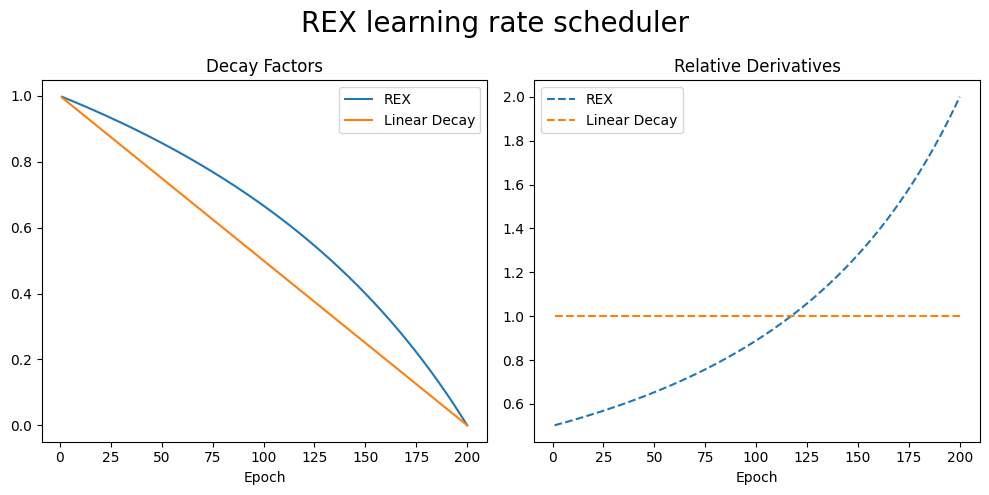

In [49]:
visualize_REX(200)

**A note on the two plots**: On the *left*, we have plotted the decay factors instead of the learning rates (i.e., $\eta_t/\eta_0$ instead of $\eta_t$). On the *right*, we have plotted the derivatives (of the decay factors $\eta_t/\eta_0$) of the two schedules (i.e., REX and linear) *relative to the derivative of the decay factor of the linear schedule*. Hence, the shown derivative of the decay factor of the linear schedule is constantly equal to $1$ by design. This way of illustrating the (relative) derivatives helps us better understand how the learning rate is adjusted in the REX schedule *compared to the linear decay schedule*.

We can see that, in the *REX* schedule, the learning rate is decreased less strongly in the earlier epochs and much more strongly in the later epochs compared to the *linear decay* schedule. *In theory*, this should allow our network to *learn more quickly* in the early stages of training while simultaneously keeping fluctuations in performance to a minimum at the later stages of training (as the learning rate is driven to $0$ more aggressively toward the end than in the linear schedule).

Finally, let's actually implement the *REX* learning rate scheduler.

In [50]:
class ReflectedExponentialLR(torch.optim.lr_scheduler.LRScheduler):
    def __init__(self, optimizer, num_epochs, last_epoch=-1, verbose=False):
        self.num_epochs = num_epochs
        super().__init__(optimizer, last_epoch, verbose)

    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)
        
        decay_factor = 2 * (self.num_epochs-self.last_epoch) / (2*self.num_epochs - self.last_epoch)
        
        return [base_lr * decay_factor for base_lr in self.base_lrs]


<a id='deep-learning-pipeline-augmentation'></a>

### 3.5 Transforming and augmenting images
As mentioned before, there are $57$ different cards in a standard *Dobble* deck (for an unknown reason, there are only $55$ playing cards in the retailed version). This gives us $(57 \times 56) / 2 = 1,596$ different pairs of cards, which is the size of the full dataset that we'll be working with. If we split this dataset into training, validation, and testing sets using ratios of $70\%$, $15\%$, and $15\%$, respectively, we end up with a training set consisting of $1117$ images. We are already increasing the variability in our training data a bit by randomly assigning a position to each playing card in every epoch. Here, we want to improve the variability in our training data a bit further, by introducing image augmentation techniques.

However, before we do so, let's take care of the normalization of our data first. Since the images that we'll be using differ quite drastically from natural images, we will *not* be using the mean and standard deviation of common image databases such as [ImageNet](https://www.image-net.org/index.php). Instead, we use our `compute_mean_std` function to compute the mean and standard deviation of our data. We will do this as follows: Since the background color of each tile image is randomly chosen to be an arbitrary color (sampled from a uniform distribution), the average background color will be gray with a brightness of $50\%$ (if we sample often enough). Hence, we can compute the mean and standard deviation of the datasets that we'll be working with as follows:

In [51]:
# full_set_gray_bg = DobbleDataset(
#     pairs_csv, bg_color=(127, 127, 127), preprocess=transforms.ToTensor()
#     )

# BATCH_SIZE = 16
# full_set_gray_bg_loader = torch.utils.data.DataLoader(full_set_gray_bg, batch_size=BATCH_SIZE)

# MEAN, STD = calculate_mean_std(full_set_gray_bg_loader)

# MEAN = [round(val, 4) for val in MEAN]
# STD = [round(val, 4) for val in STD]

# print(f'MEAN: {MEAN}')
# print(f'STD: {STD}')

**Note**: Since the computation is a bit time-consuming (roughly 10 secs on GPU), we have commented it out and simply hard-coded the values that we obtained from the computation:

In [52]:
MEAN = [0.6474, 0.6423, 0.6246]
STD = [0.2536, 0.2535, 0.2654]

With these values at hand, we can define our **preprocessing transform** already.

In [53]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
    ])

Later on, we will also be working with **ResNet** architectures of different depths. These require their own preprocessing as specified [here](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18).

**Note**: In PyTorch, [ResNet architectures](https://pytorch.org/vision/main/models/resnet.html) are available with those depths that were introduced in the original paper [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf), i.e., 18, 34, 50, 101, and 152. The following **pre-trained weights** are available:
- `IMAGENET1K_V1`: Available for all ResNet models
- `IMAGENET1K_V2`: Available for all ResNet models *except* ResNet18 and ResNet34

Depending on the pre-trained models that are used (if any), the preprocessing differs in the first resizing step. We will **implement** the correct **preprocessing pipelines for both sets of pre-trained weights** (i.e., V1 and V2).

In [54]:
preprocess_imagenet1k_v1 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        )
    ])

preprocess_imagenet1k_v2 = transforms.Compose([
    transforms.Resize(232),  # only difference
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        )
    ])

With the preprocessing out of the way, we now turn to image augmentation. First, we implement a series of augmentations that we apply to the **images of the individual playing cards**.

In [55]:
individual_transform = transforms.RandomApply([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomPerspective(distortion_scale=0.4),
    transforms.RandomAffine(
        degrees=(0, 180),
        translate=(0.05, 0.05),
        scale=(0.8, 0.9)
        )
    ], p=0.75)

Additionally, we will also apply a simple augmentation to the **tile images of pairs of cards**.

In [56]:
tile_transform = transforms.ColorJitter(brightness=0.25, contrast=0.25)

Let's investigate the effects of these augmentations!

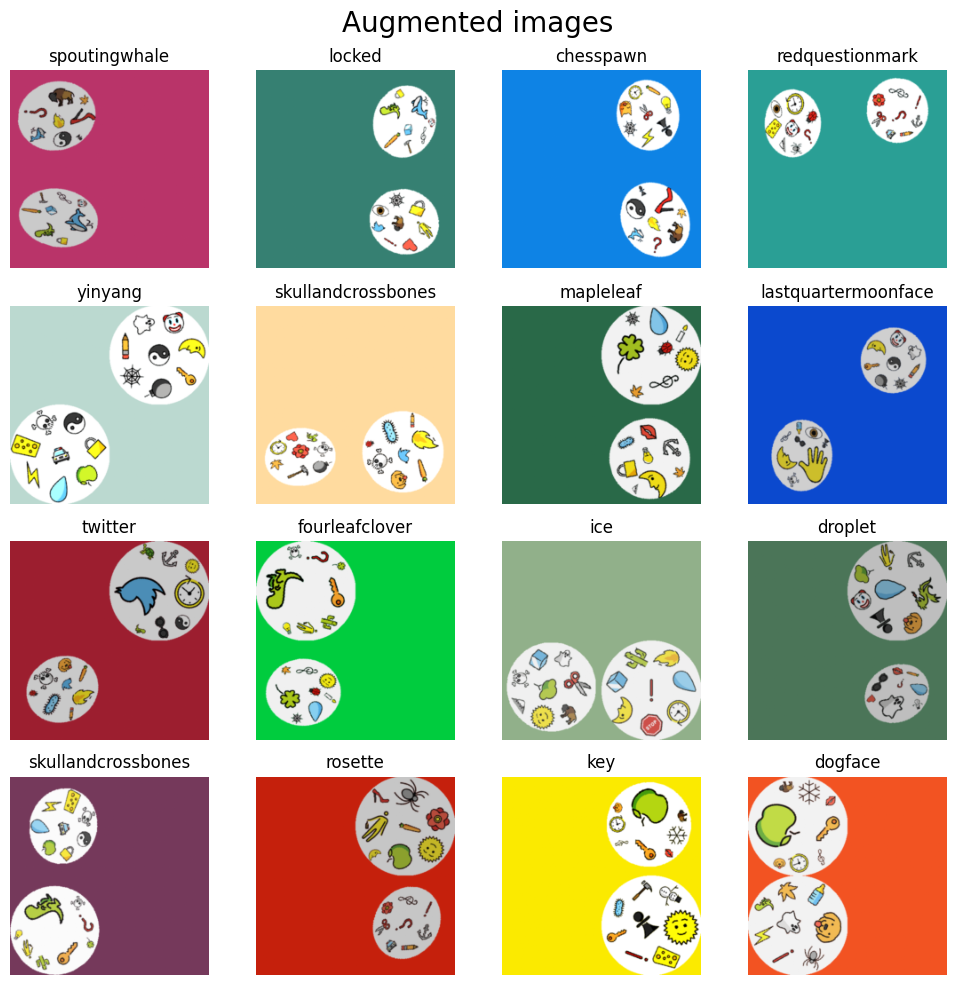

In [57]:
full_set = DobbleDataset(
    pairs_csv,
    individual_transform=individual_transform,
    tile_transform=tile_transform,
    preprocess=preprocess
    )

BATCH_SIZE = 16
NUM_WORKERS = 2

full_loader = torch.utils.data.DataLoader(
    full_set, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True, sampler=None
    )

images, labels = next(iter(full_loader))
images_np = images.numpy()
images_np = np.transpose(images_np, (0, 2, 3, 1))  # (B, H, W, C)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

for i, (image, label) in enumerate(zip(images_np, labels)):
    # Extract individual color channels
    r, g, b = image.transpose((2, 0, 1))

    # Undo normalization
    r = r * STD[0] + MEAN[0]
    g = g * STD[1] + MEAN[1]
    b = b * STD[2] + MEAN[2]

    # Recombine color channels and clip values to unit interval (necessary b/c of computational inaccuracies)
    image = np.dstack((r, g, b))
    image = np.clip(image, 0, 1)

    ax = axes[i]
    ax.imshow(image)
    ax.set_title(labels_dict[label.item()])
    ax.axis('off')

plt.suptitle('Augmented images', size=20)
plt.tight_layout()
plt.show()

<a id='resnet-models'></a>

## Part 4: *ResNet* models with different depths
In this section, we will train *ResNet* models of different depths (keeping all other parameters constant) to see if the depth itself has an impact on the model performance. First, let's **set the device** that we'll be using for training purposes.

In [58]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'\nDevice that is currently used: {str(DEVICE).upper()}\n')


Device that is currently used: CUDA



Next, let's set some (fixed) **parameters** that we'll use during training.

In [59]:
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15

NUM_EPOCHS = 300

BATCH_SIZE = 16
NUM_WORKERS = 2

LR = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4

CRITERION = nn.CrossEntropyLoss()
NUM_CLASSES = 57

PRINT_FREQ = 25
SAVE_FREQ = 50

For each available depth (i.e., 18, 34, 50, 101, 152), we will have to **create the corresponding ResNet model** and replace the fully connected layer with one that has the appropriate size. Since this would lead to repetitive code, we write another little helper function that does this job for us.

In [60]:
def create_resnet_model(num_classes, depth, weights=None):
    """Create a ResNet model of specified depth and with a specified number of classes.

    Args:
        num_classes (int): The number of output classes.
        depth (int): The depth of the ResNet model.  Supported depths are 18, 34, 50, 101, and 152.
        weights (str): If provided, the function loads pre-trained weights for the specified depth. 
            Defaults to 'None', in which case the model will be randomly initialized.

    Returns:
        torch.nn.Module: The created ResNet model with the desired fully connected layer.

    Raises:
        ValueError: If an invalid depth is provided. Supported depths are 18, 34, 50, 101, and 152.
    """
    # Create model with specified pre-trained (or randomly initialized) weights
    if depth == 18:
        model = models.resnet18(weights=weights)
    elif depth == 34:
        model = models.resnet34(weights=weights)
    elif depth == 50:
        model = models.resnet50(weights=weights)
    elif depth == 101:
        model = models.resnet101(weights=weights)
    elif depth == 152:
        model = models.resnet152(weights=weights)
    else:
        raise ValueError("Invalid depth. Supported depths are 18, 34, 50, 101, and 152.")

    # Replace fully connected layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features=in_features, out_features=num_classes)

    return model


Also, the **datasets and data loaders** that we will be using will remain the same. So let's just create them right now.

In [61]:
train_csv, val_csv, test_csv = split_dataset(pairs_csv, TRAIN_RATIO, VAL_RATIO)

# We'll use image augmentation for our training set ...
train_set = DobbleDataset(
    train_csv,
    individual_transform=individual_transform,
    tile_transform=tile_transform,
    preprocess=preprocess
    )

# ... but not for our validation or testing sets
val_set = DobbleDataset(val_csv, preprocess=preprocess)
test_set = DobbleDataset(test_csv, preprocess=preprocess)

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True, sampler=None
    )

val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True, sampler=None
    )

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True, sampler=None
    )

<a id='resnet-models-resnet18'></a>

### 4.1 ResNet-18
To make sure that our `train` function works as expected, we will first train Resnet-18 for 100 epochs, and then try to resume training and train it for another 200 epochs so that we have trained for a total of 300 epochs, as set by our argument `NUM_EPOCHS`.

In [62]:
resnet18 = create_resnet_model(NUM_CLASSES, depth=18)

optimizer = torch.optim.SGD(
    params=resnet18.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY
    )

scheduler = ReflectedExponentialLR(optimizer, NUM_EPOCHS)

checkpoint_dir = 'resnet18'
# We deviate from 'NUM_EPOCHS' to test our 'train' function ...
num_epochs = 100

resnet18_train_logs = train(
    resnet18, train_loader, val_loader, CRITERION, optimizer, DEVICE, num_epochs, scheduler,
    checkpoint=None, print_freq=PRINT_FREQ, save_freq=SAVE_FREQ, checkpoint_dir=checkpoint_dir
    )

Epoch [025/100]   Train   Loss=4.0492   Acc=1.79    Val   Loss=4.0836   Acc=0.00
Epoch [050/100]   Train   Loss=4.0424   Acc=2.51    Val   Loss=4.0881   Acc=0.00
Epoch [075/100]   Train   Loss=3.9638   Acc=2.95    Val   Loss=4.0448   Acc=2.51
Epoch [100/100]   Train   Loss=3.6939   Acc=5.73    Val   Loss=3.9676   Acc=5.02


In [63]:
resnet18 = create_resnet_model(NUM_CLASSES, depth=18)

optimizer = torch.optim.SGD(
    params=resnet18.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY
    )

scheduler = ReflectedExponentialLR(optimizer, NUM_EPOCHS)

num_epochs = 200  # ... and here we train the remaining 200 epochs!

# Load the checkpoint that we saved earlier ...
checkpoint = torch.load('../models/resnet18/epoch-100_acc-5.0209.pt')

# ... and resume the training progress.
resnet18_train_logs = train(
    resnet18, train_loader, val_loader, CRITERION, optimizer, DEVICE, num_epochs, scheduler,
    checkpoint=checkpoint, print_freq=PRINT_FREQ, save_freq=SAVE_FREQ, checkpoint_dir=checkpoint_dir
    )

Epoch [125/300]   Train   Loss=2.8383   Acc=19.34    Val   Loss=3.4502   Acc=13.39
Epoch [150/300]   Train   Loss=1.5878   Acc=53.27    Val   Loss=1.9919   Acc=38.91
Epoch [175/300]   Train   Loss=0.4750   Acc=89.70    Val   Loss=0.4705   Acc=87.45
Epoch [200/300]   Train   Loss=0.1533   Acc=97.94    Val   Loss=0.1250   Acc=98.33
Epoch [225/300]   Train   Loss=0.0623   Acc=99.46    Val   Loss=0.0407   Acc=100.00
Epoch [250/300]   Train   Loss=0.0416   Acc=99.64    Val   Loss=0.0285   Acc=100.00
Epoch [275/300]   Train   Loss=0.0276   Acc=100.00    Val   Loss=0.0173   Acc=100.00
Epoch [300/300]   Train   Loss=0.0224   Acc=99.91    Val   Loss=0.0155   Acc=100.00
